## Part2 - Logistic Regression

In [47]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

np.seterr('ignore')

#data directory
path = './credit/'

In [48]:
#data manipulation functions
def rescale(M, a=0., b=1.):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [49]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def cross_alpha(X, y, algorithm, params):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    cv_err = np.empty((5,5))
    i = 0 #index of fold
    
    for tr_index,ts_index in kf:
        j = 0 #index of parameter
        X_tr, X_ts = X[tr_index], X[ts_index]
        y_tr, y_ts = y[tr_index], y[ts_index]
        for param in params:
            beta,_ = algorithm(X_tr, y_tr, param)
            cv_err[i,j] = error_rate(X_ts, y_ts, beta)
            j += 1
        i += 1
        
    #arrays with mean costs for each alpha
    cv_mean = np.mean(cv_err, axis=0)
    return params[np.argmin(cv_mean)], cv_err

"""
Function to generate histogram of winners (alphas)
"""
def make_hist(winners,params):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(params[i]==winners)

    labels = map(str,params)
    pos = np.arange(len(labels))
    width = 1.0
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.ylabel('Frequency')
    plt.bar(pos, freqs, width, color='0.5')
    plt.show()

def solve_logistic(algorithm, params, data_func=None):
    winners = list()

    for i in xrange(20):
        #Loading dataset
        tr_file = path+'credit-tr-{0}.npy'.format(i)
        ts_file = path+'credit-ts-{0}.npy'.format(i)
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        #Adding column of 1's
        m,n = X_tr.shape
        X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)

        if data_func is not None:
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_ts = ts_data[:,:-1]
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        #Adding column of 1's
        m,n = X_ts.shape
        X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)

        alpha,cv_err = cross_alpha(X_tr, y_tr, algorithm, params)
        winners.append(alpha)
        beta,it = algorithm(X_tr, y_tr, alpha)
        print "###########################################################"
        print "Dataset: {0}".format(i)
        print 'Best alpha: {0}'.format(alpha)
        fig = plt.figure()
        fig.set_figheight(7)
        fig.set_figwidth(13)
        plt.xlabel('Parameters')
        plt.ylabel('Cross-Validation Error Rates')
        plt.boxplot(cv_err, showmeans=True, meanline=True)
        plt.xticks([1, 2, 3, 4, 5], map(str,params))
        plt.show()
        print 'Training error rate: {0}'.format(error_rate(X_tr,y_tr,beta))
        print 'Testing error rate: {0}'.format(error_rate(X_ts,y_ts,beta))
        print 'N° iterations: {0}'.format(it)
        print 'Beta: {0}'.format(beta)
        print "###########################################################"
        print '\n'
    make_hist(winners,params)

### Mean functions

In [62]:
#Sigmoid function
def sigmoid(z):
    return 1./(1.+np.exp(-z))

#Overall cost function for logistic regression (log likelihood function)
"""
Computing l this way, make it more stable numerically (no overflows)
"""
def l(X, y, beta):
    y1_mask = y.astype(bool)
    y0_mask = np.logical_not(y1_mask)
    f = sigmoid(np.dot(X,beta))
    return (np.log(f[y1_mask])).sum() + (np.log(1-f[y0_mask])).sum()
    

#Error rate for logistic regression
def error_rate(X, y, beta):
    h = np.round(sigmoid(np.dot(X,beta)))
    h = h.astype(int)
    y = y.astype(int)
    m, = h.shape
    return np.logical_xor(h,y).sum()/np.float(m)

#Stochastic gradient ascent for logistic regression
def gd_stochastic(X, y, alpha, eps=1e-3, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)+1.
    for i in xrange(max_iter):
        l0 = l1
        for m in xrange(M):
            beta += alpha*(y[m]-sigmoid(np.dot(X[m],beta)))*X[m]
        l1 = l(X,y,beta)+1.
        if np.abs(l1-l0)/np.abs(l0) < eps: break
    return (beta,i+1)

#Newton-Raphson method for logistic regression
def nr_logistic(X, y, alpha, eps=1e-3, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)+1.
    for i in xrange(max_iter):
        l0 = l1
        f = sigmoid(np.dot(X,beta))
        W = np.diag(f*(1-f))
        Hess = -1*np.dot(X.T, np.dot(W, X))
        Dl = np.dot(X.T, y-f)
        #when it converges, Hess became singular
        try:
            beta -= alpha*np.linalg.solve(Hess, Dl)
        except np.linalg.LinAlgError:
            break
        l1 = l(X, y, beta)+1.
        if np.abs(l1-l0)/np.abs(l0) < eps: break
    return (beta,i+1)

## 1)

In [66]:
params1 = np.array([1.0, 0.8, 0.6, 0.4, 0.2]) #params for Newton Raphson
params2 = np.linspace(1e-2, 1e-3, 5, endpoint=True) #params for gradient Ascent online

### Newton-Raphson with raw data

###########################################################
Dataset: 0
Best alpha: 1.0


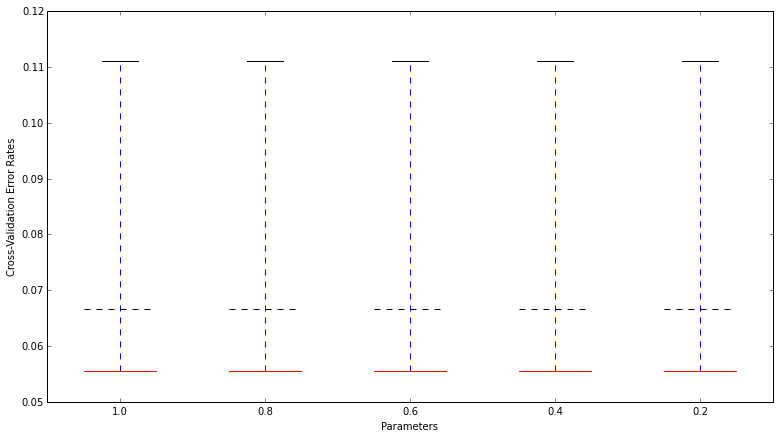

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [ 557.40052882    5.03373347  -21.50346179   -0.88369795  233.24039993
 -602.60602669    1.07503379]
###########################################################


###########################################################
Dataset: 1
Best alpha: 1.0


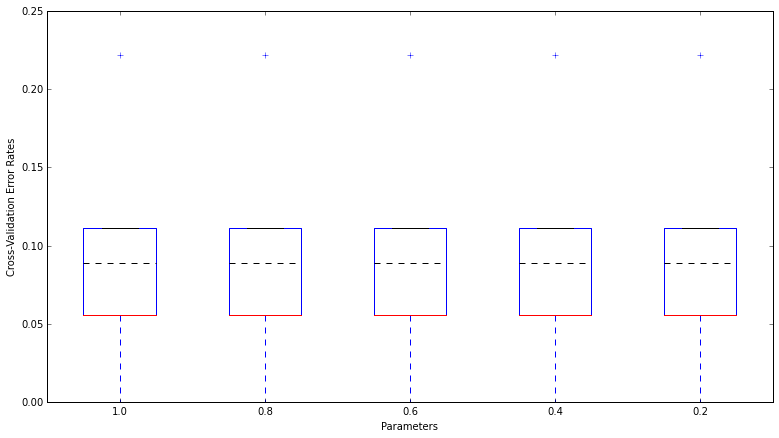

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [ 803.96047692   -2.58676118  -23.66285693   -0.89249041  238.87694435
 -589.82292873    1.42426665]
###########################################################


###########################################################
Dataset: 2
Best alpha: 1.0


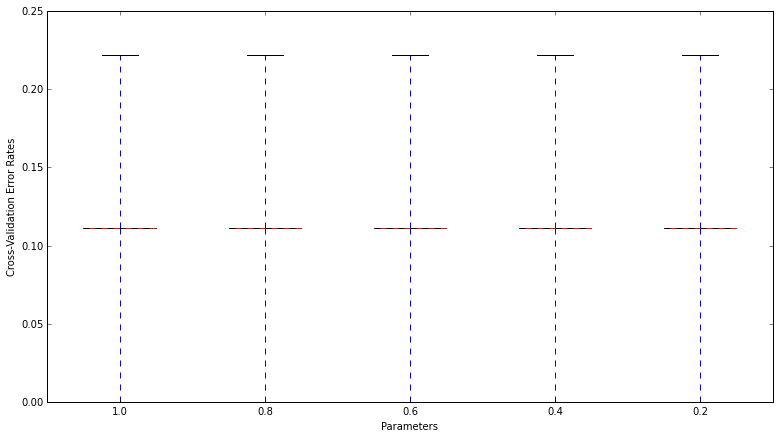

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 16
Beta: [ 321.62401952   -0.82091783   -7.48156618   -0.48223212   77.07758793
 -223.82876206   -2.38299215]
###########################################################


###########################################################
Dataset: 3
Best alpha: 1.0


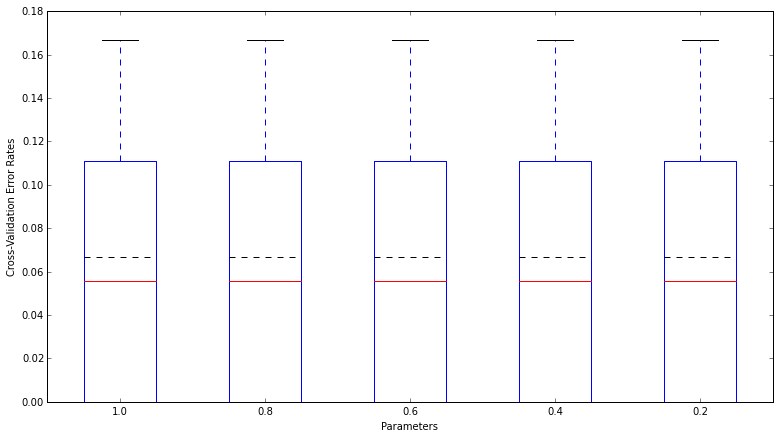

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 16
Beta: [ 227.8163269     1.22363675   -9.284471     -0.24155396   95.42796971
 -230.79608359    1.63595002]
###########################################################


###########################################################
Dataset: 4
Best alpha: 1.0


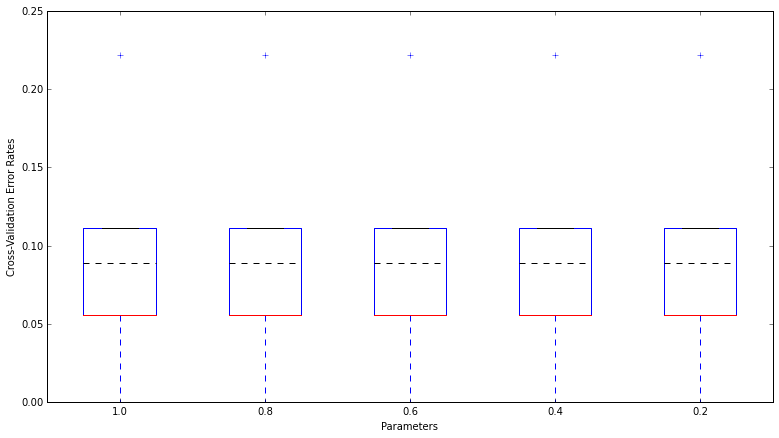

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 18
Beta: [ 1028.55218363     6.79321876   -31.13055291    -1.66086333   338.19553309
  -823.21600052   -11.62615028]
###########################################################


###########################################################
Dataset: 5
Best alpha: 1.0


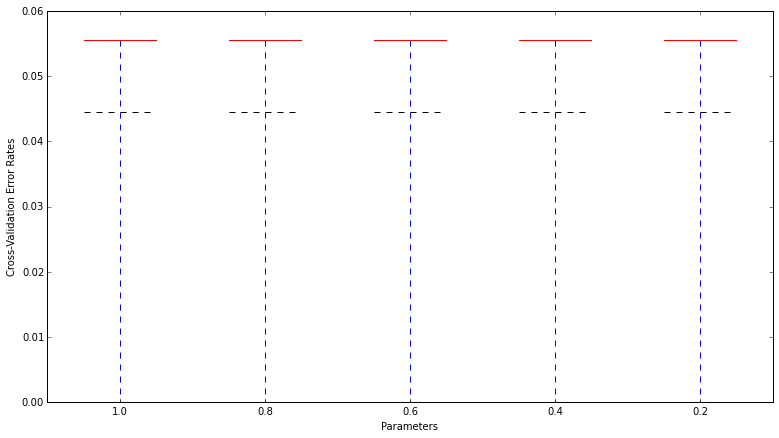

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 19
Beta: [ 3102.66631471    12.77115671  -101.88462873    -4.14475363  1002.83846165
 -2531.96628383    -5.32626199]
###########################################################


###########################################################
Dataset: 6
Best alpha: 1.0


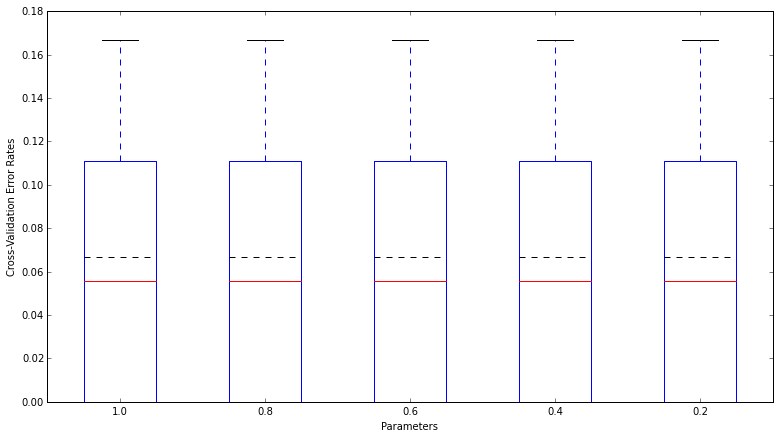

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 16
Beta: [  5.59695031e+02  -2.02929670e+00  -1.55843517e+01  -5.77558303e-01
   1.27019320e+02  -3.08747779e+02   3.54593487e-03]
###########################################################


###########################################################
Dataset: 7
Best alpha: 1.0


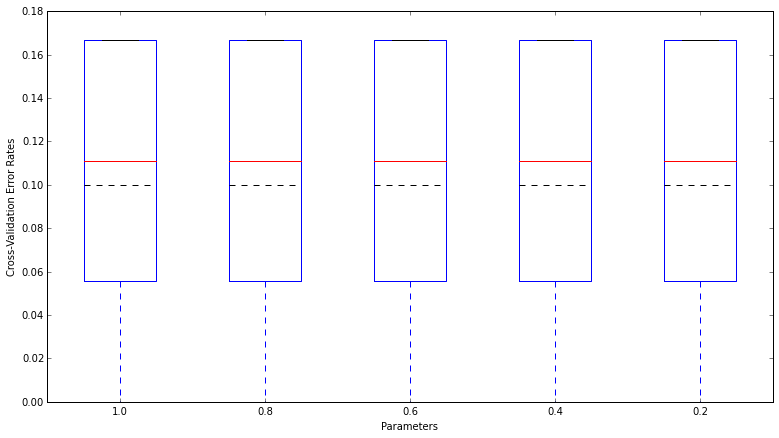

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 13
Beta: [  1.34667512e+02   8.85337985e-01  -4.84507577e+00  -1.92775205e-01
   5.38407585e+01  -1.36768888e+02  -6.12498898e-02]
###########################################################


###########################################################
Dataset: 8
Best alpha: 1.0


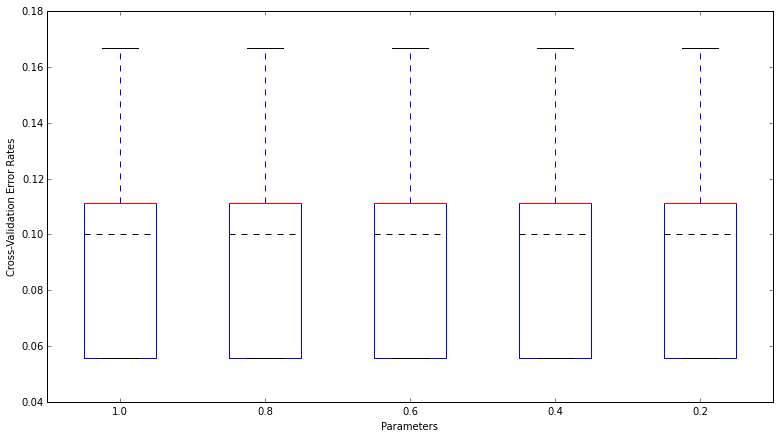

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [  6.94861684e+02   1.73289822e-02  -2.21536344e+01  -9.39146527e-01
   1.97221049e+02  -4.78611181e+02   1.29290727e+00]
###########################################################


###########################################################
Dataset: 9
Best alpha: 1.0


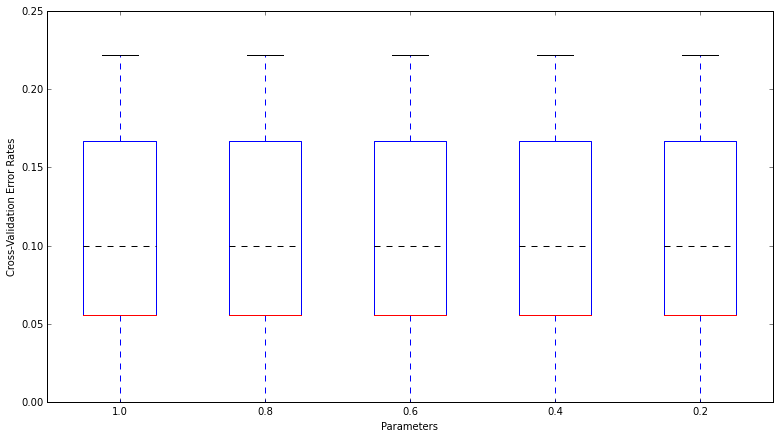

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 14
Beta: [ 332.81256177    1.74306215  -11.315591     -0.47126117  118.5854157
 -296.83568509   -0.74699334]
###########################################################


###########################################################
Dataset: 10
Best alpha: 1.0


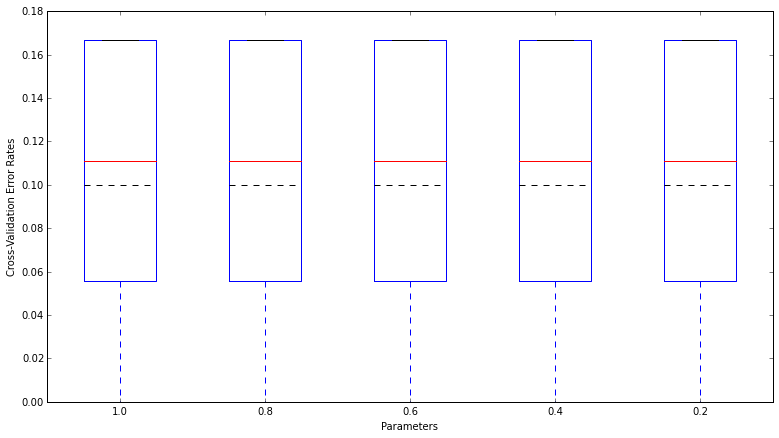

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [ 646.70052002    3.26920725  -19.69960332   -0.98948962  201.55711355
 -479.99336288   -5.45879445]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.2


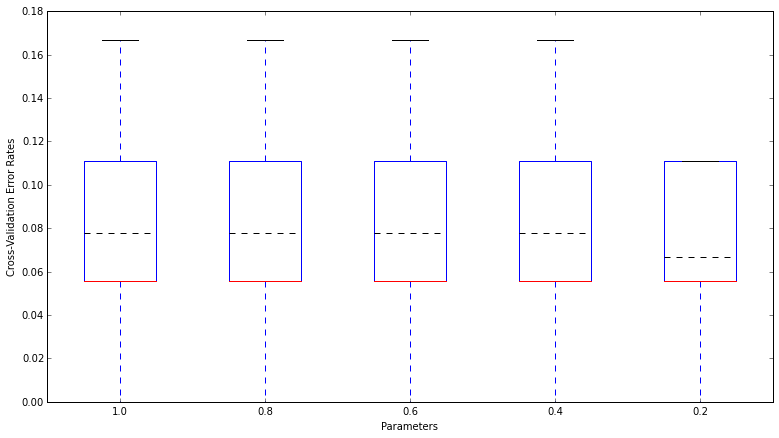

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 60
Beta: [ 311.35954529    1.6213912   -10.47313457   -0.43610508  109.28465947
 -276.96493909   -0.68534105]
###########################################################


###########################################################
Dataset: 12
Best alpha: 1.0


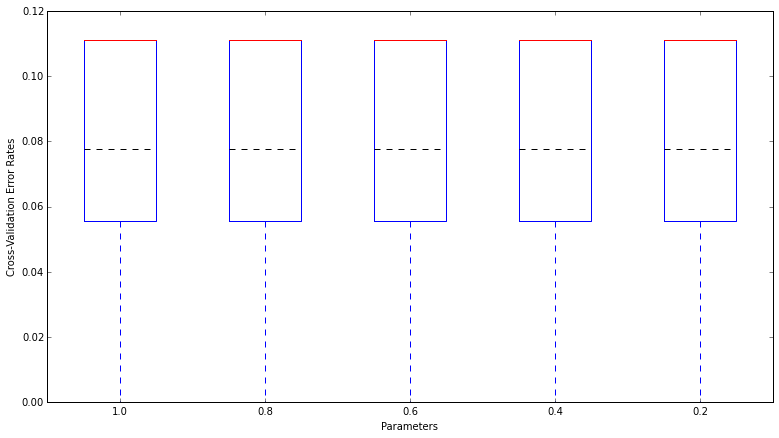

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 18
Beta: [ 1219.51607949     7.51717204   -36.94151102    -1.97055712   389.67962142
  -945.6352524    -12.29105697]
###########################################################


###########################################################
Dataset: 13
Best alpha: 1.0


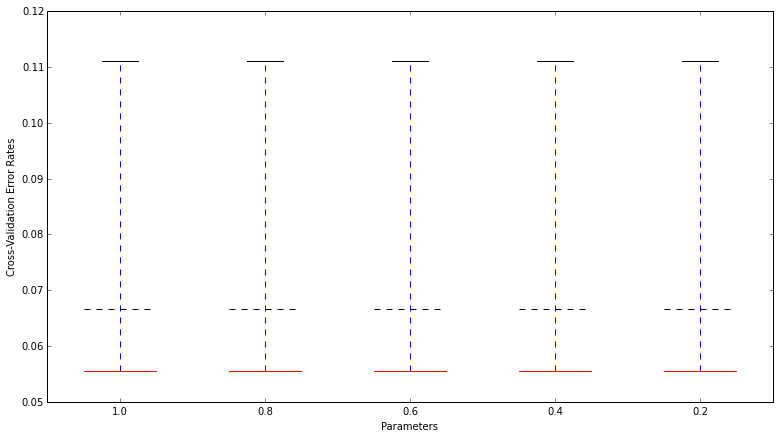

Training error rate: 0.522222222222
Testing error rate: 0.566666666667
N° iterations: 15
Beta: [  5.00282505e+21  -8.21546111e+20  -1.56016420e+21   3.18963940e+21
  -4.23599524e+21  -5.67720689e+21   4.36567027e+21]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.2


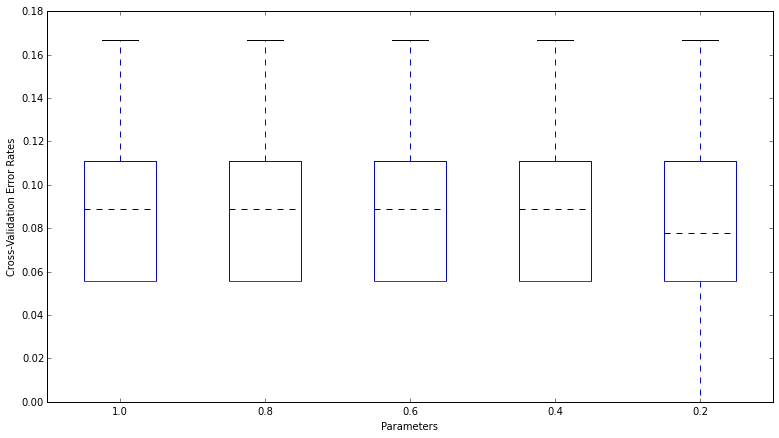

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 59
Beta: [ 305.62918132    1.61237603  -10.40776346   -0.43340283  108.54717769
 -271.29560745   -0.6820929 ]
###########################################################


###########################################################
Dataset: 15
Best alpha: 1.0


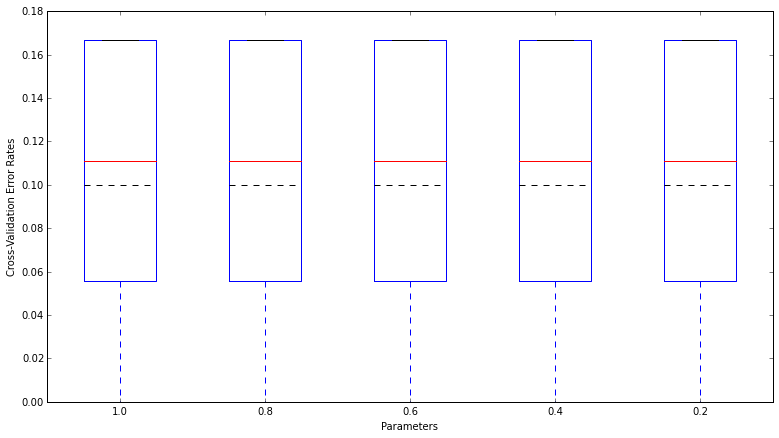

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 15
Beta: [ 337.68573663    1.74420702  -11.32346423   -0.47160594  119.08284612
 -302.91768911   -0.74802212]
###########################################################


###########################################################
Dataset: 16
Best alpha: 1.0


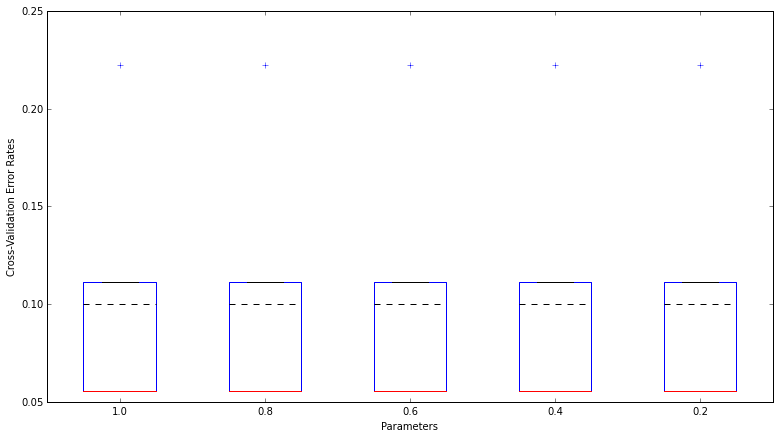

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 16
Beta: [ 358.03333313    2.36013518   -9.8969716    -0.68334829   99.90584547
 -219.89713476   -5.0942113 ]
###########################################################


###########################################################
Dataset: 17
Best alpha: 1.0


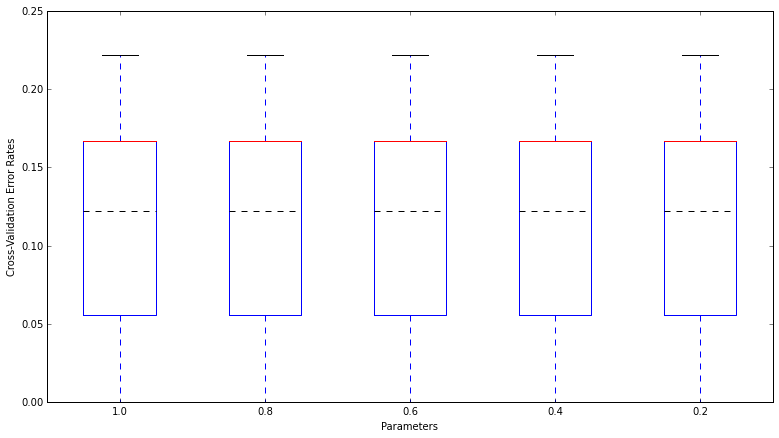

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 18
Beta: [ 1244.60749469     7.6757396    -37.68369241    -2.00983266   348.87014107
  -819.64737819   -12.53087377]
###########################################################


###########################################################
Dataset: 18
Best alpha: 1.0


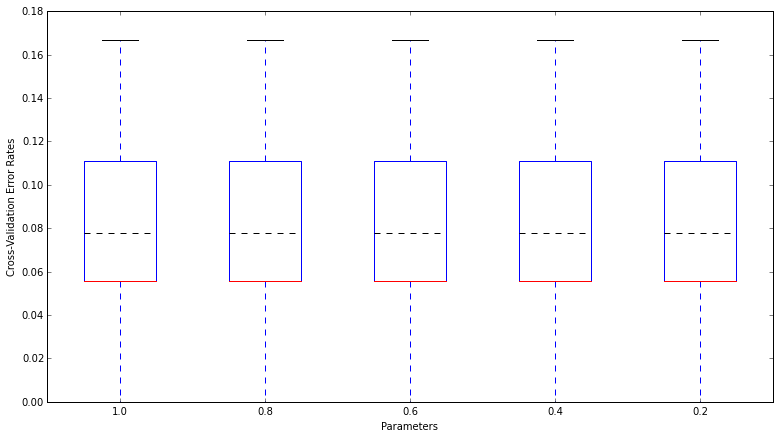

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 18
Beta: [ 911.74352633    6.50060479  -29.45113972   -1.27209237  352.37422328
 -875.76051015  -11.22050058]
###########################################################


###########################################################
Dataset: 19
Best alpha: 1.0


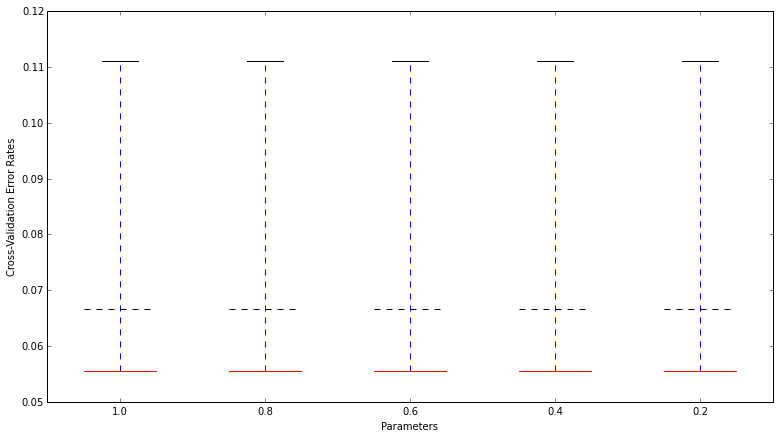

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 17
Beta: [ 670.90220619    0.86457524  -22.03454126   -0.92937043  188.54888149
 -455.19510963    1.27682023]
###########################################################




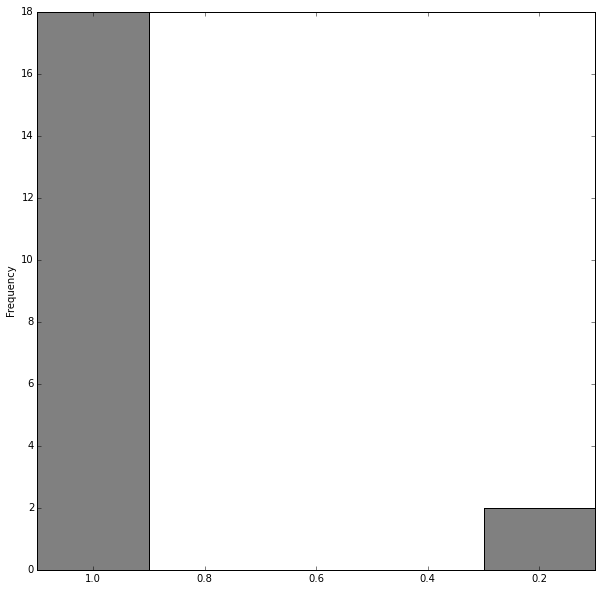

In [67]:
solve_logistic(nr_logistic, params1)

### Newton-Raphson with rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 1.0


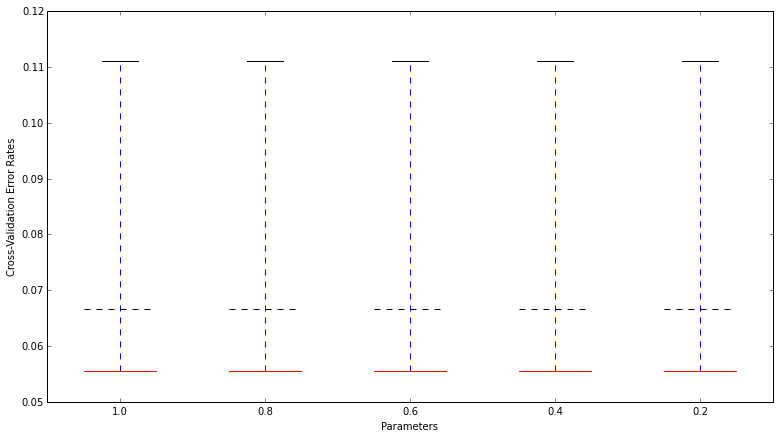

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 17
Beta: [   73.98701993   180.88595375  -814.87368456  -183.34781483  1865.9231994
  -602.60602669    22.16612173]
###########################################################


###########################################################
Dataset: 1
Best alpha: 1.0


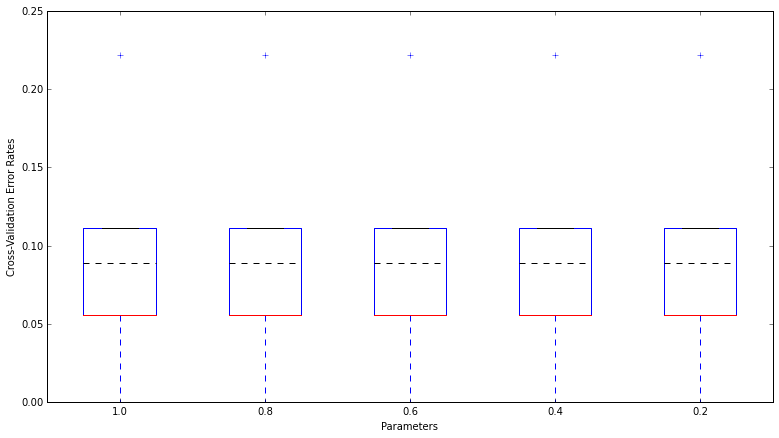

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [  270.08614165   -92.95461638  -920.67443738  -186.00765746  1911.0155548
  -589.82292873    32.52412583]
###########################################################


###########################################################
Dataset: 2
Best alpha: 1.0


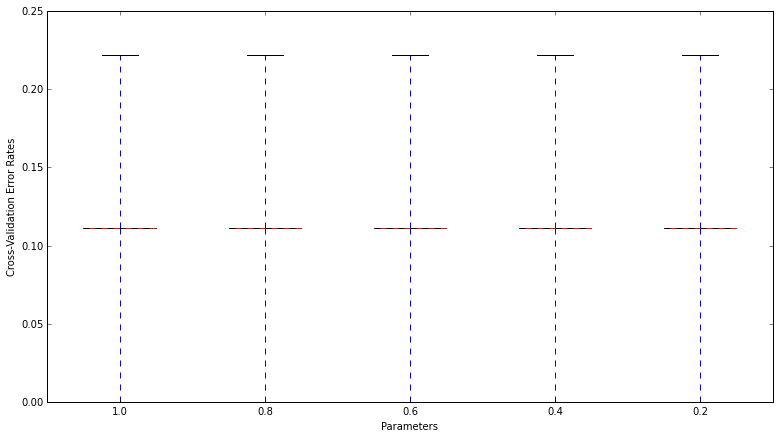

Training error rate: 0.0
Testing error rate: 0.2
N° iterations: 16
Beta: [ 129.41109149  -29.49947682 -291.09277688  -99.7149553   539.54311553
 -223.82876206  -54.41729385]
###########################################################


###########################################################
Dataset: 3
Best alpha: 1.0


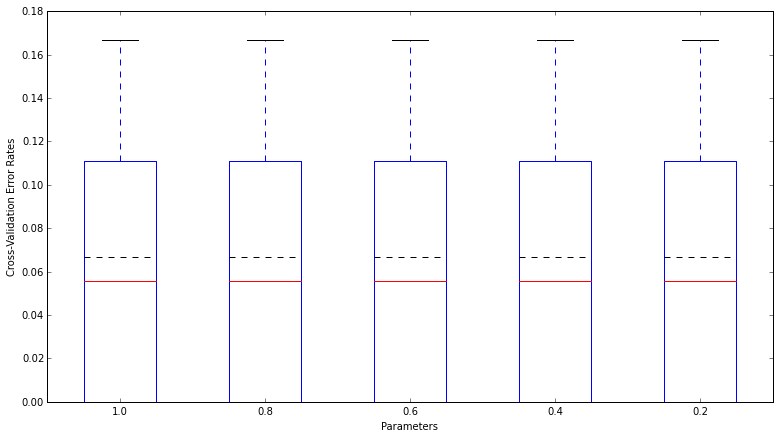

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 16
Beta: [  28.06244213   45.4883902  -351.83502838  -50.47461392  763.4237577
 -230.79608359   35.62886459]
###########################################################


###########################################################
Dataset: 4
Best alpha: 1.0


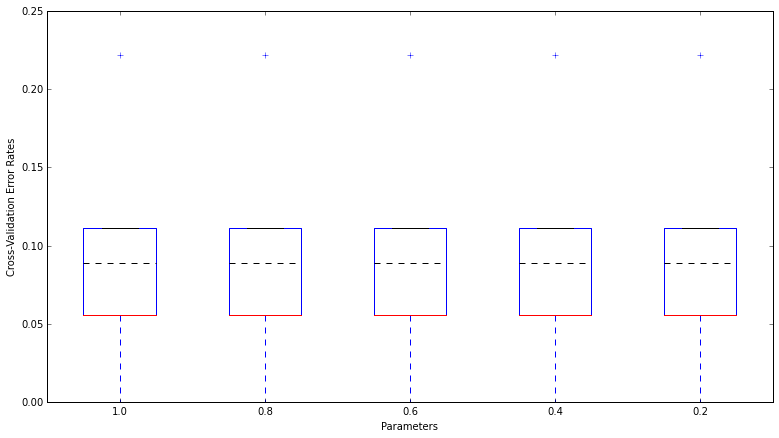

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 18
Beta: [  222.56451047   247.09925631 -1211.22755261  -347.05054982  2705.56426471
  -823.21600052  -238.73950819]
###########################################################


###########################################################
Dataset: 5
Best alpha: 1.0


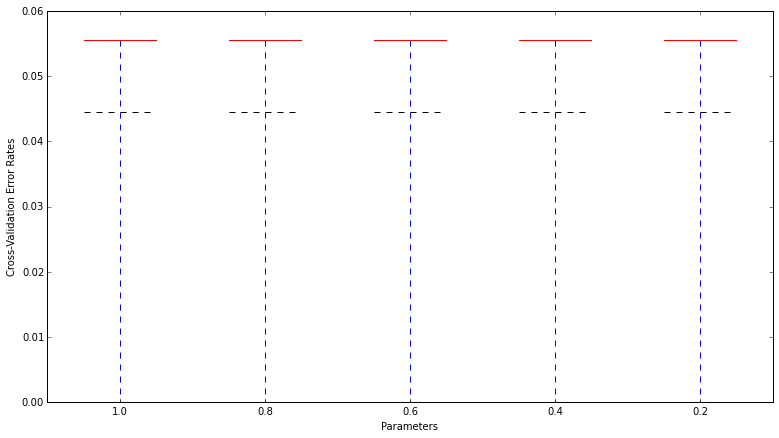

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 19
Beta: [  727.02167678   464.54316252 -3964.12713443  -866.05291016  8022.70769306
 -2531.96628354  -121.62892101]
###########################################################


###########################################################
Dataset: 6
Best alpha: 1.0


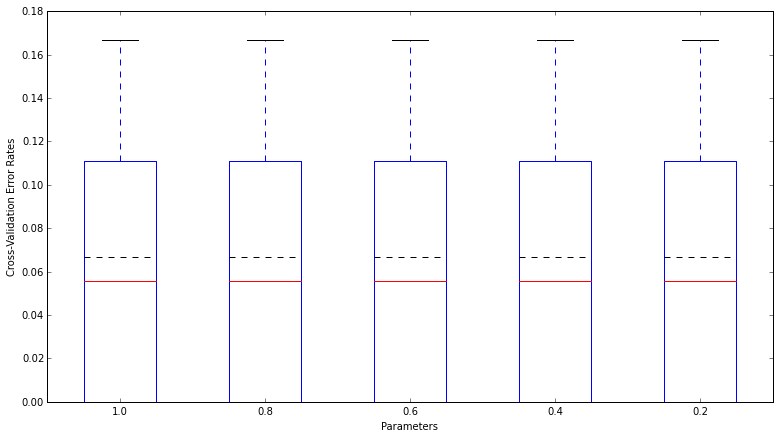

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 16
Beta: [  2.00549108e+02  -7.54385974e+01  -5.58589917e+02  -1.20685383e+02
   8.89135241e+02  -3.08747779e+02   8.09739048e-02]
###########################################################


###########################################################
Dataset: 7
Best alpha: 1.0


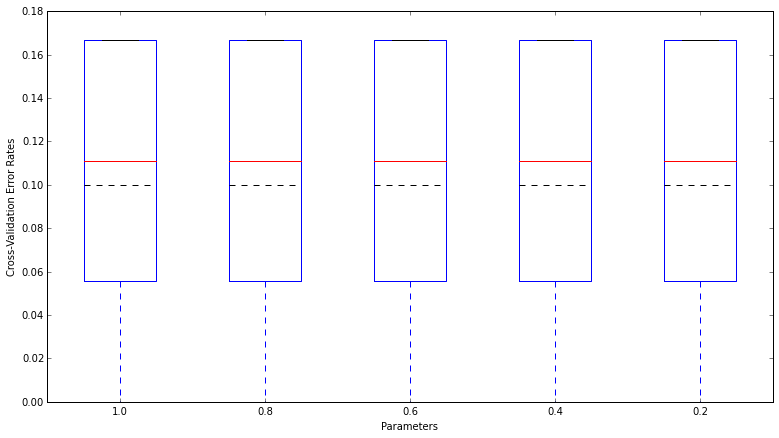

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 13
Beta: [  22.87692171   32.91221826 -188.51220795  -40.28068792  430.72606792
 -136.76888827   -1.33394298]
###########################################################


###########################################################
Dataset: 8
Best alpha: 1.0


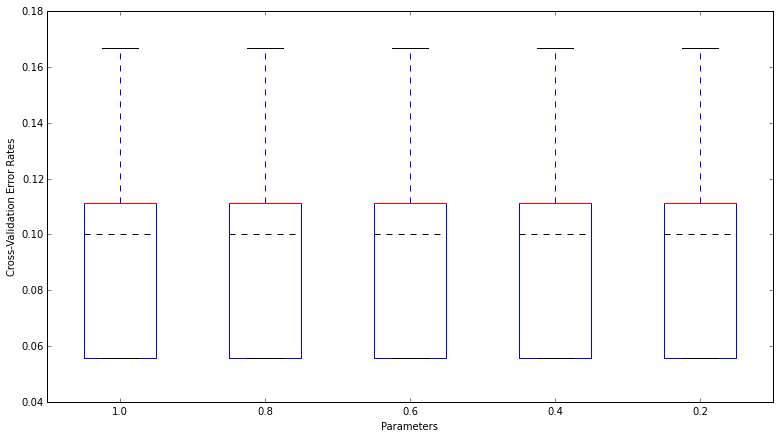

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [  1.95775187e+02   6.44200582e-01  -8.61953608e+02  -1.94852170e+02
   1.38054734e+03  -4.78611181e+02   2.95244426e+01]
###########################################################


###########################################################
Dataset: 9
Best alpha: 1.0


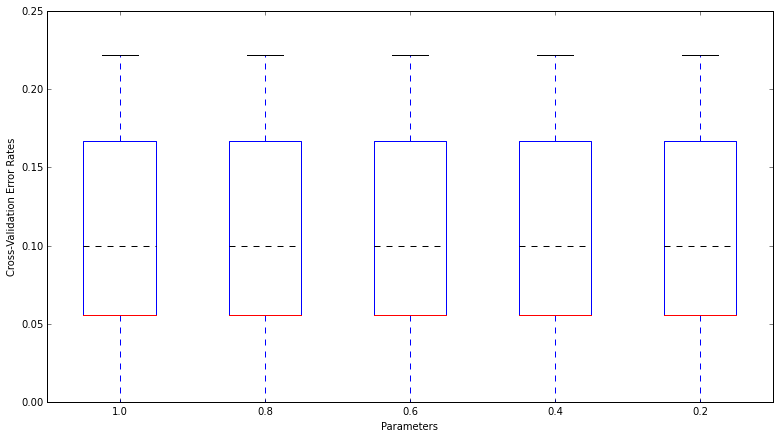

Training error rate: 0.0222222222222
Testing error rate: 0.166666666667
N° iterations: 14
Beta: [  66.62105157   64.79789953 -440.26701454  -98.47077707  948.6833256
 -296.83568509  -17.05811591]
###########################################################


###########################################################
Dataset: 10
Best alpha: 1.0


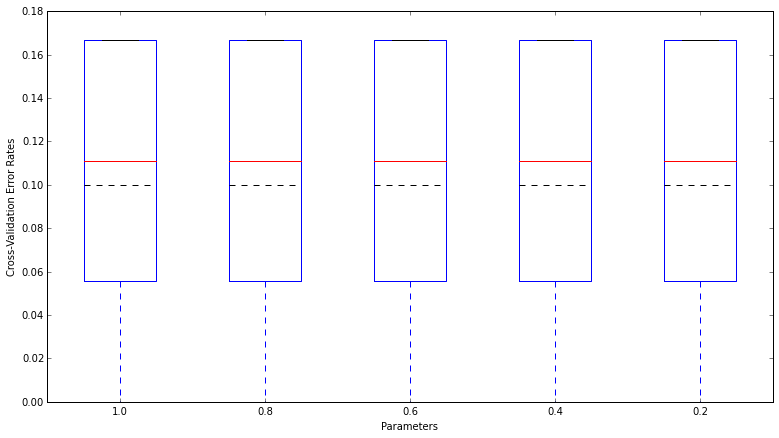

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 17
Beta: [  148.75509923   121.53196204  -766.47216592  -205.29724988  1410.89979485
  -479.99336288  -124.65539248]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.2


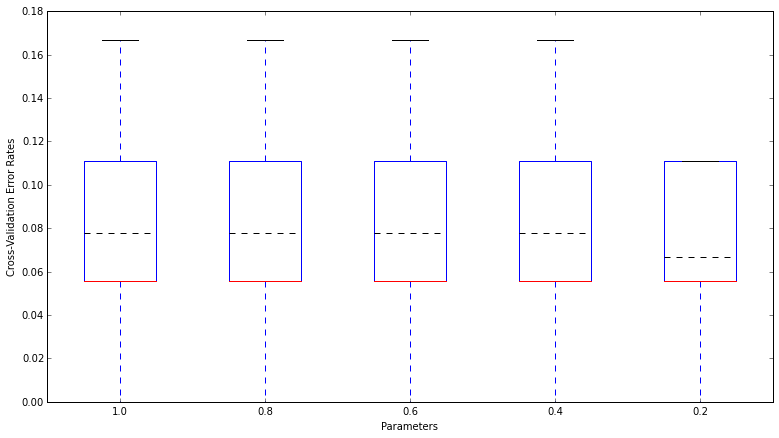

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 60
Beta: [  64.24649624   60.27481267 -407.48872001  -91.12761199  874.27727578
 -276.96493909  -14.85545266]
###########################################################


###########################################################
Dataset: 12
Best alpha: 1.0


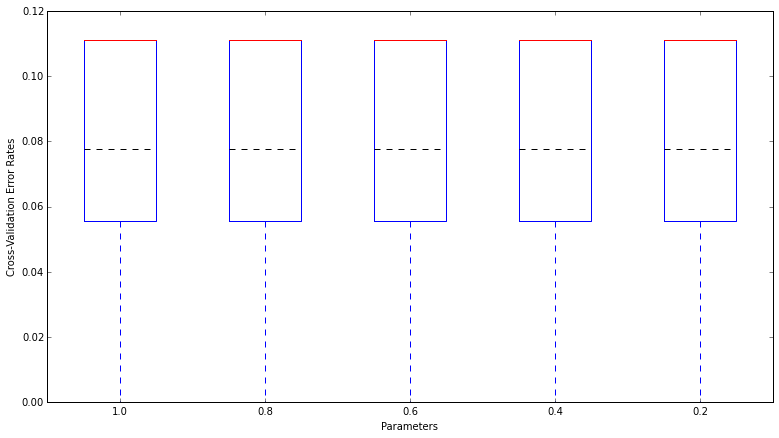

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 18
Beta: [  254.74419845   279.4489912  -1437.32031092  -411.75106723  3117.43697137
  -945.6352524   -266.42095095]
###########################################################


###########################################################
Dataset: 13
Best alpha: 1.0


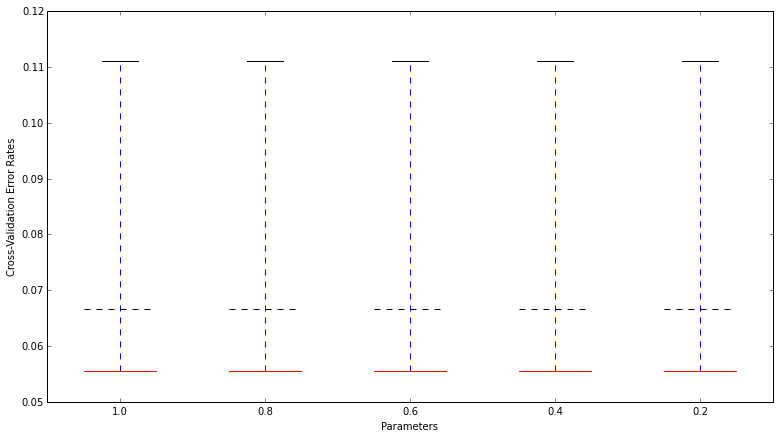

Training error rate: 0.588888888889
Testing error rate: 0.733333333333
N° iterations: 15
Beta: [ -5.28771840e+22   3.64201581e+22   7.26488911e+22  -2.18541514e+23
   8.59929188e+21   1.40653372e+22  -3.27874314e+22]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.2


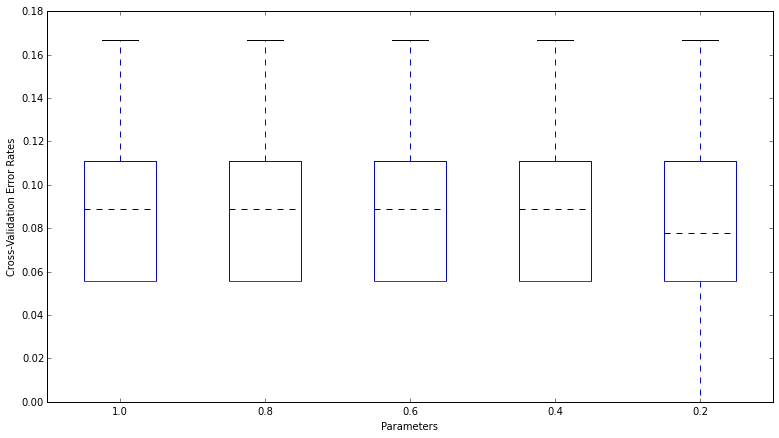

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 59
Beta: [  60.83736641   57.94032937 -404.9452608   -90.5602156   868.37742152
 -271.29560745  -15.57606875]
###########################################################


###########################################################
Dataset: 15
Best alpha: 1.0


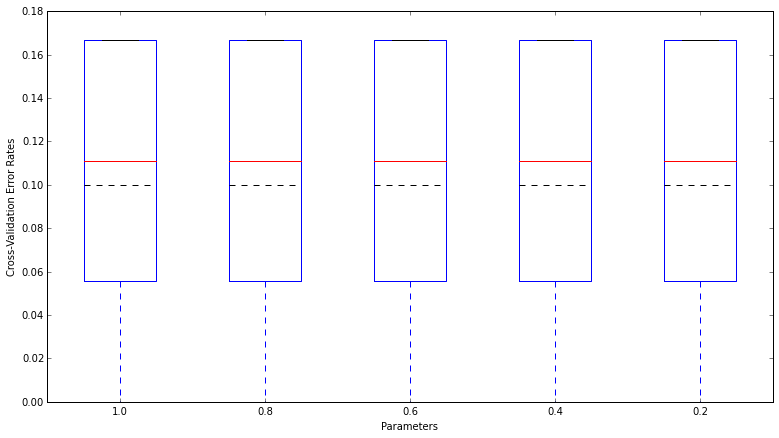

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 15
Beta: [  70.43728102   64.8404601  -429.10267715  -98.54281734  952.66276899
 -302.91768911  -14.49292861]
###########################################################


###########################################################
Dataset: 16
Best alpha: 1.0


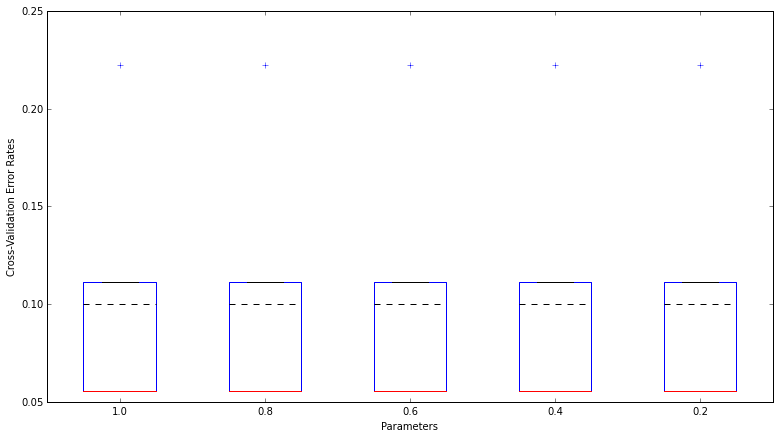

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 16
Beta: [  85.77041861   85.84850117 -380.46927937 -142.78672032  799.24676373
 -219.89713476 -116.32988091]
###########################################################


###########################################################
Dataset: 17
Best alpha: 1.0


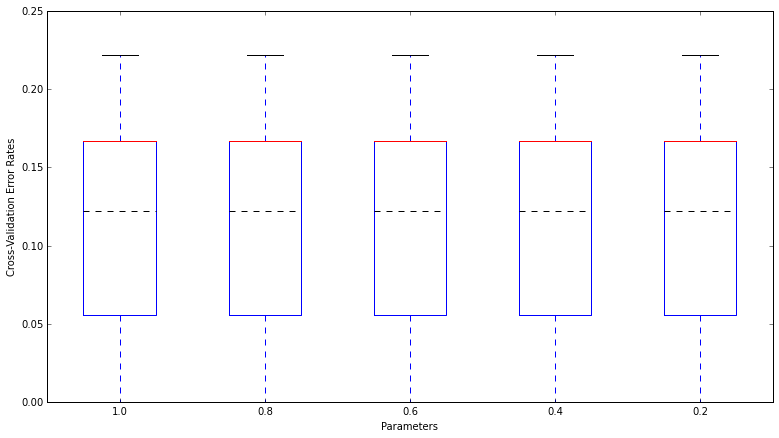

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 18
Beta: [  201.67282898   285.34370079 -1407.33517678  -419.97045566  2790.96112859
  -819.64737819  -271.61921982]
###########################################################


###########################################################
Dataset: 18
Best alpha: 1.0


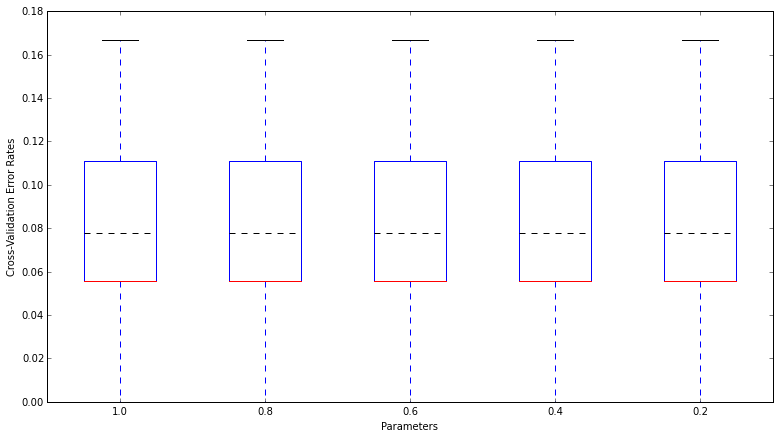

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 18
Beta: [  142.26964227   230.75034301 -1145.88494437  -265.8137783   2818.99378625
  -875.76051015  -256.22798501]
###########################################################


###########################################################
Dataset: 19
Best alpha: 1.0


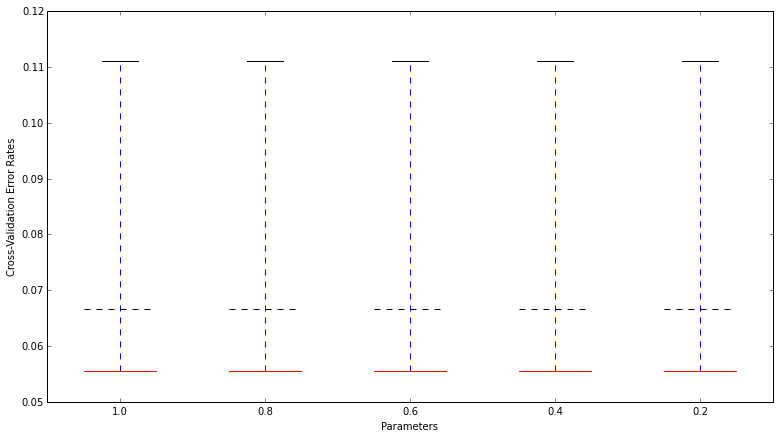

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 17
Beta: [  175.97293131    31.06829514  -789.78406223  -192.67791377  1319.84217041
  -455.19510963    27.67635535]
###########################################################




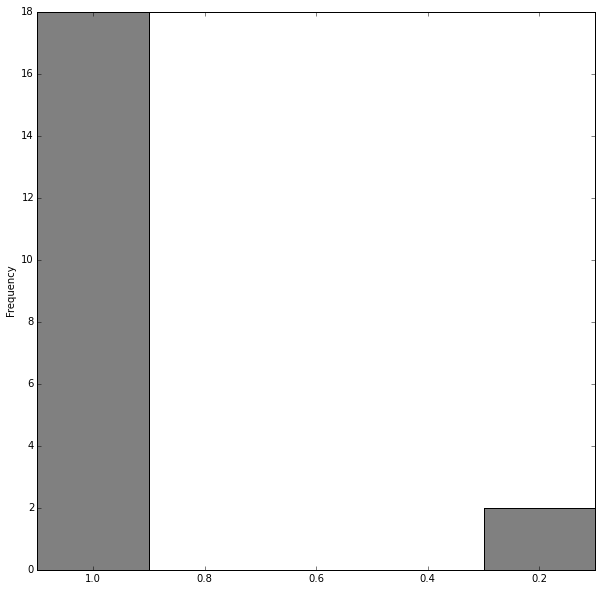

In [68]:
solve_logistic(nr_logistic, params1, rescale)

### Newton-Raphson with normalized data

###########################################################
Dataset: 0
Best alpha: 1.0


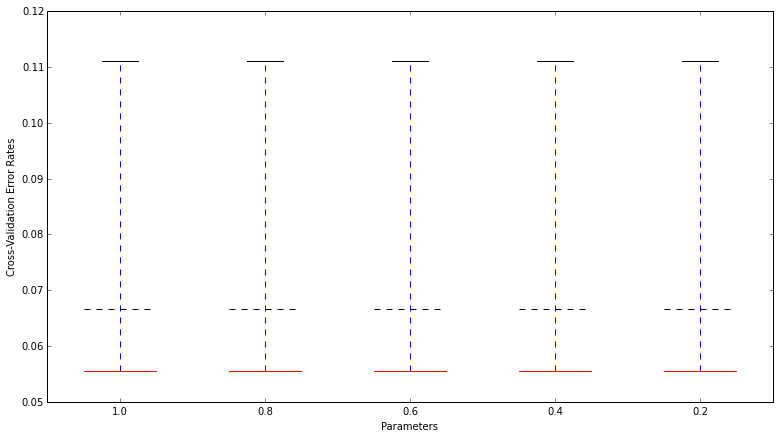

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 17
Beta: [ -10.17632429   51.90495222 -223.06462833  -72.5822921   446.92953071
 -290.39247559    5.29862312]
###########################################################


###########################################################
Dataset: 1
Best alpha: 1.0


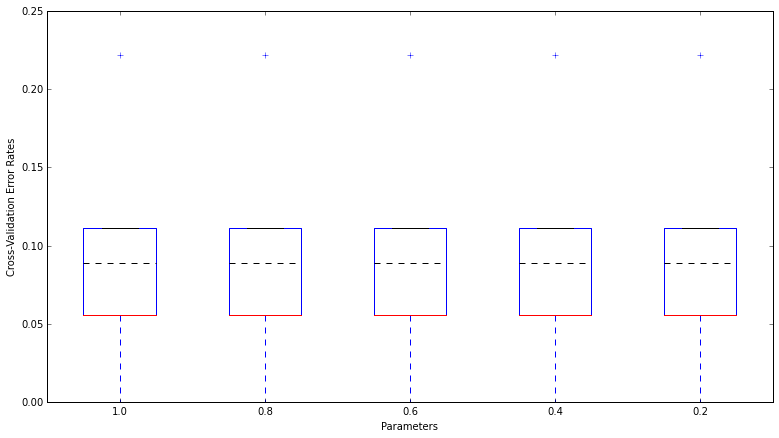

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [  -7.87113982  -26.68713019 -260.18819588  -75.55996586  449.83597505
 -290.21371906    7.13016985]
###########################################################


###########################################################
Dataset: 2
Best alpha: 1.0


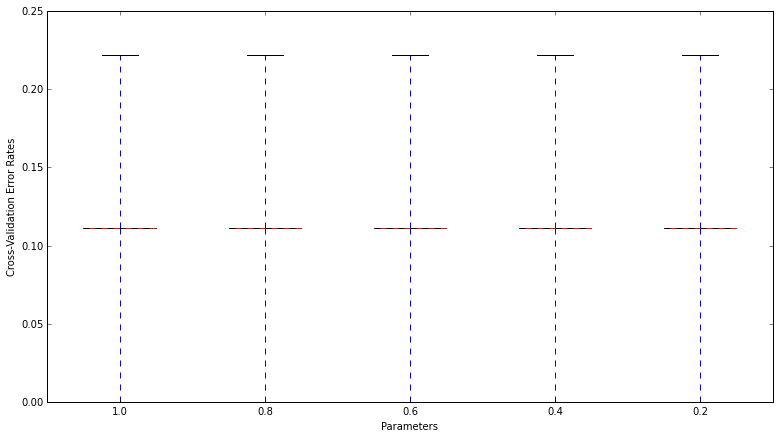

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 16
Beta: [  -9.87050944   -8.53453836  -78.40744137  -38.80536518  142.03112781
 -110.13165868  -11.62175137]
###########################################################


###########################################################
Dataset: 3
Best alpha: 1.0


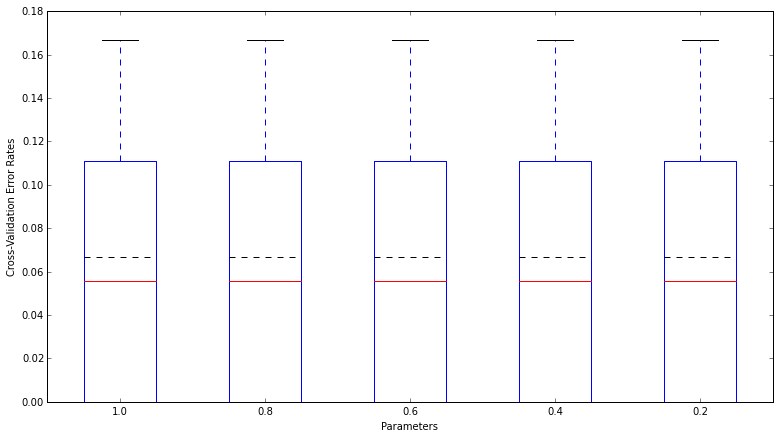

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 16
Beta: [   4.36340793   12.85186612  -98.84213455  -20.48457846  190.91483649
 -111.89724591    7.75177716]
###########################################################


###########################################################
Dataset: 4
Best alpha: 1.0


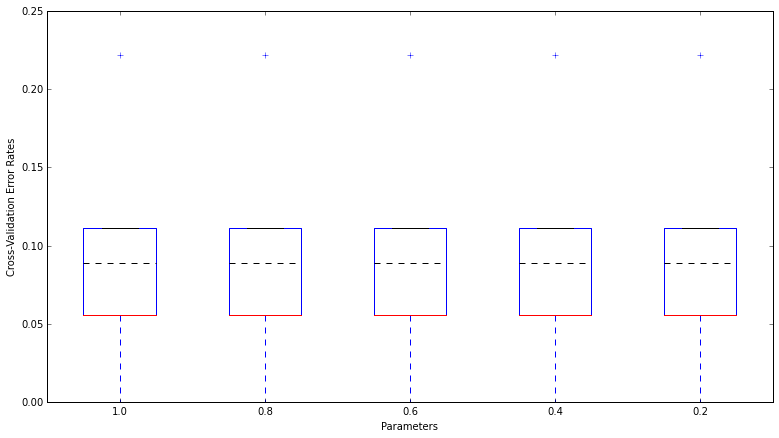

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 18
Beta: [-110.40523286   70.22282043 -331.88452705 -144.97796347  664.64003278
 -381.10632277  -54.11524186]
###########################################################


###########################################################
Dataset: 5
Best alpha: 1.0


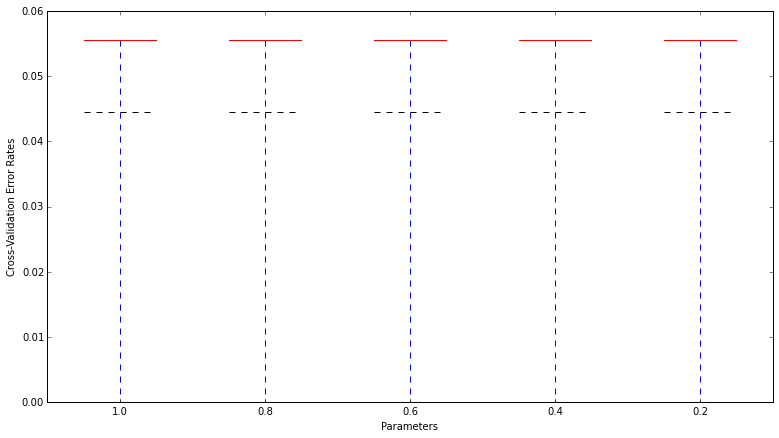

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 19
Beta: [ -163.73566562   125.62756761 -1036.92294405  -360.66906591  1862.15644972
 -1220.14039774   -26.55012512]
###########################################################


###########################################################
Dataset: 6
Best alpha: 1.0


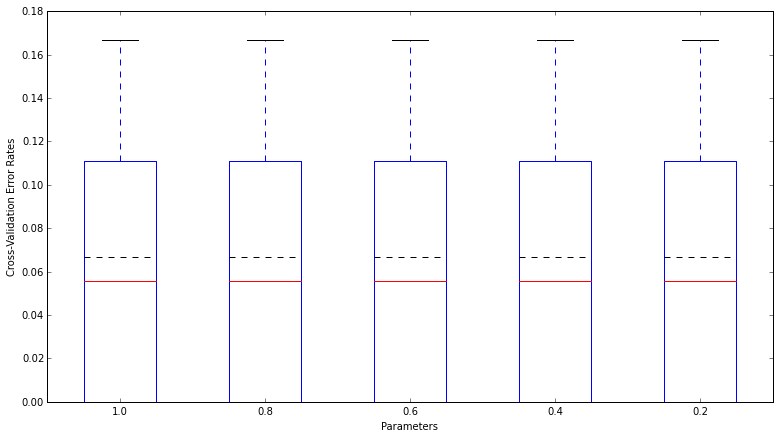

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 16
Beta: [  4.61780850e+00  -2.05104336e+01  -1.65199359e+02  -5.03252283e+01
   2.34195044e+02  -1.50513931e+02   1.87931045e-02]
###########################################################


###########################################################
Dataset: 7
Best alpha: 1.0


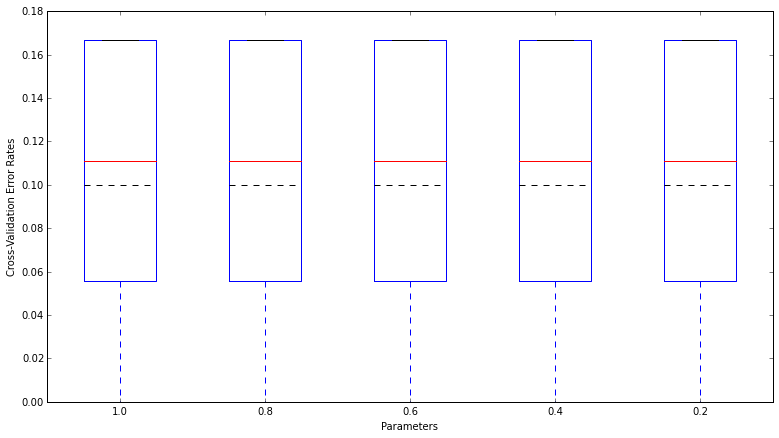

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 13
Beta: [  -6.9665165     9.2814217   -52.71054982  -16.58517204  101.45963604
  -66.30988571   -0.30293805]
###########################################################


###########################################################
Dataset: 8
Best alpha: 1.0


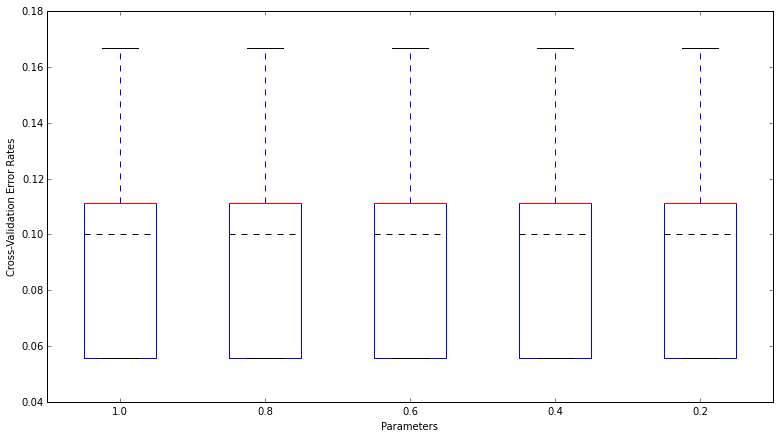

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 17
Beta: [  1.68465570e+01   1.69349087e-01  -2.34547200e+02  -7.96164121e+01
   3.60134732e+02  -2.38358311e+02   6.40950412e+00]
###########################################################


###########################################################
Dataset: 9
Best alpha: 1.0


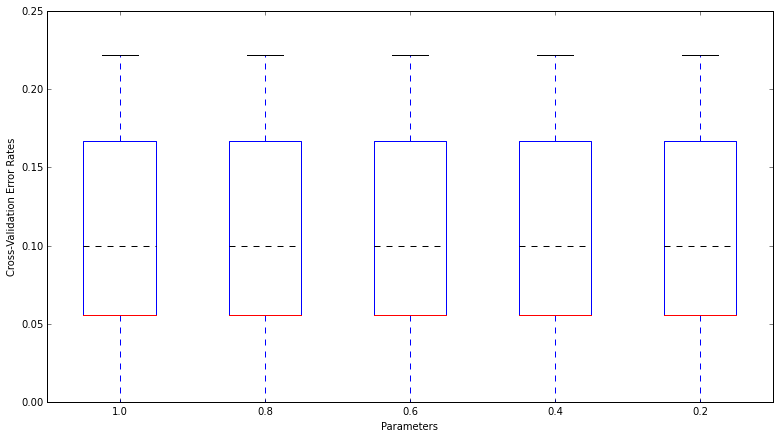

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 14
Beta: [  12.69616857   17.2684206  -118.09450303  -41.57756015  239.86397304
 -144.7068092    -3.91076464]
###########################################################


###########################################################
Dataset: 10
Best alpha: 1.0


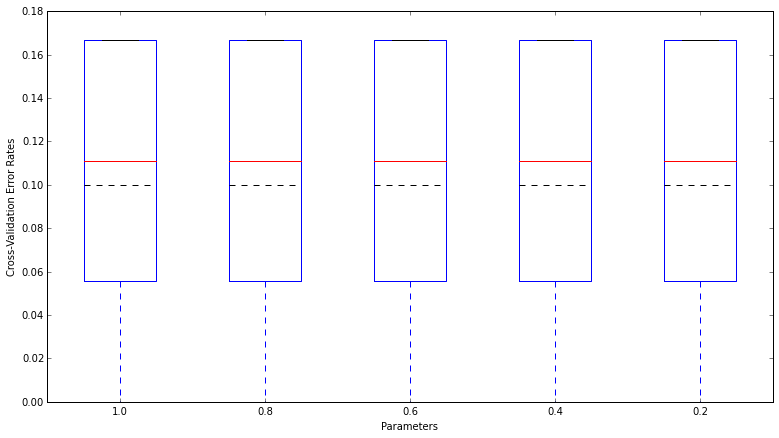

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 17
Beta: [ -22.42765249   33.31147865 -209.19236323  -86.35294546  379.69666041
 -233.99581475  -25.36350376]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.2


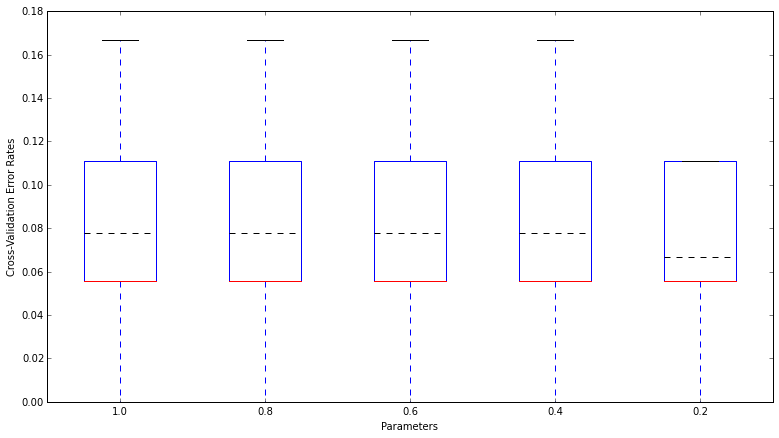

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 60
Beta: [ -24.90869533   17.19192861 -112.58449624  -35.80696592  188.44343114
 -134.28136829   -3.42641071]
###########################################################


###########################################################
Dataset: 12
Best alpha: 1.0


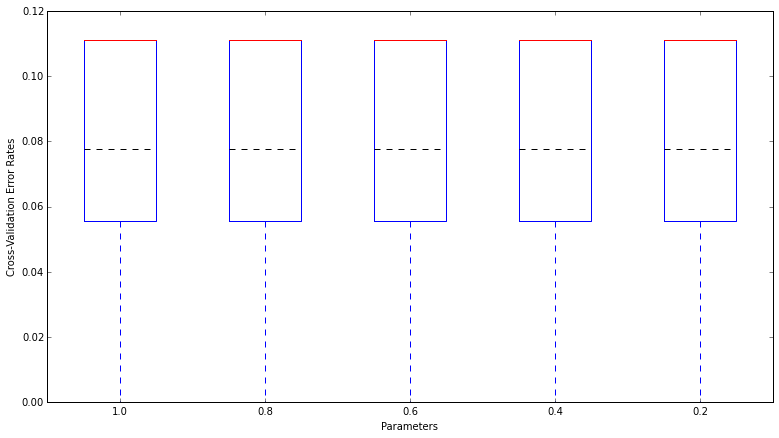

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 18
Beta: [  -0.95794814   76.11145606 -391.26640788 -171.9532044   750.63839761
 -452.65792725  -61.59124632]
###########################################################


###########################################################
Dataset: 13
Best alpha: 1.0


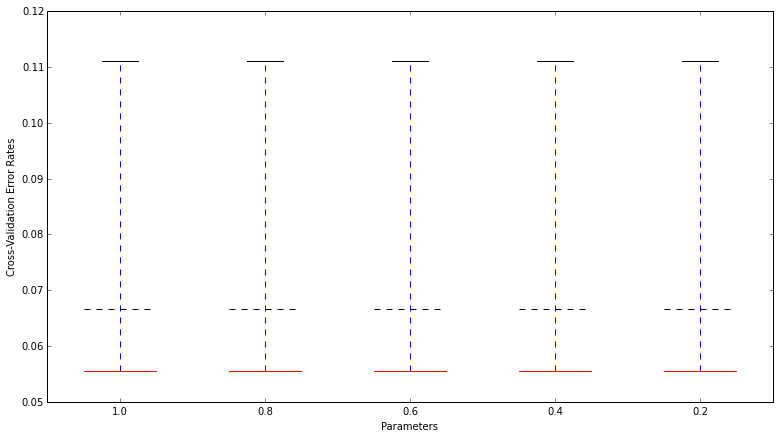

Training error rate: 0.6
Testing error rate: 0.633333333333
N° iterations: 15
Beta: [ -3.74481201e+22   5.98712743e+22   1.18306627e+23   9.60537911e+21
   2.58141335e+22   3.93927474e+22   6.08709726e+20]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.2


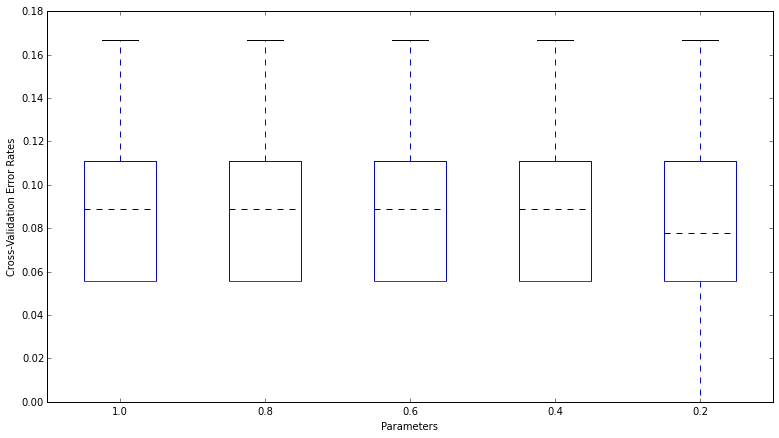

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 59
Beta: [   5.25055866   16.77909779 -114.635773    -37.36406025  215.15597411
 -132.90716154   -3.43534784]
###########################################################


###########################################################
Dataset: 15
Best alpha: 1.0


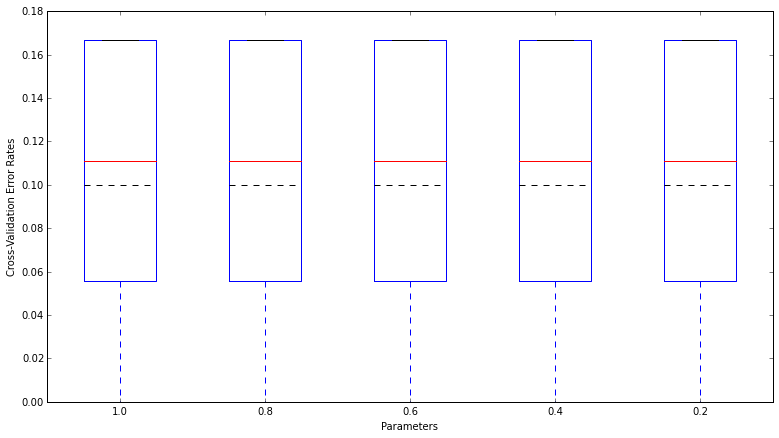

Training error rate: 0.0222222222222
Testing error rate: 0.1
N° iterations: 15
Beta: [  -1.63347339   17.87113262 -118.65274845  -41.18313311  218.84316847
 -148.39875448   -3.50005046]
###########################################################


###########################################################
Dataset: 16
Best alpha: 1.0


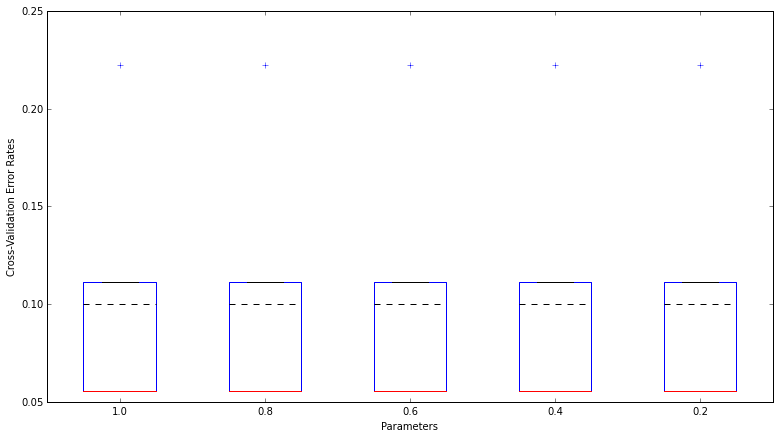

Training error rate: 0.0
Testing error rate: 0.2
N° iterations: 16
Beta: [   3.83638013   22.76214495  -99.86861005  -58.86898785  198.2794769
 -104.49220983  -26.1597695 ]
###########################################################


###########################################################
Dataset: 17
Best alpha: 1.0


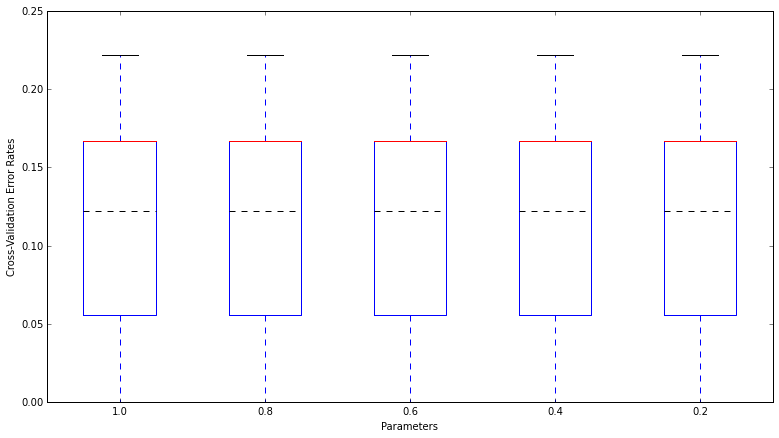

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 18
Beta: [  -3.62371227   74.387      -386.23057048 -173.19881317  660.80994238
 -389.48559255  -62.54449451]
###########################################################


###########################################################
Dataset: 18
Best alpha: 1.0


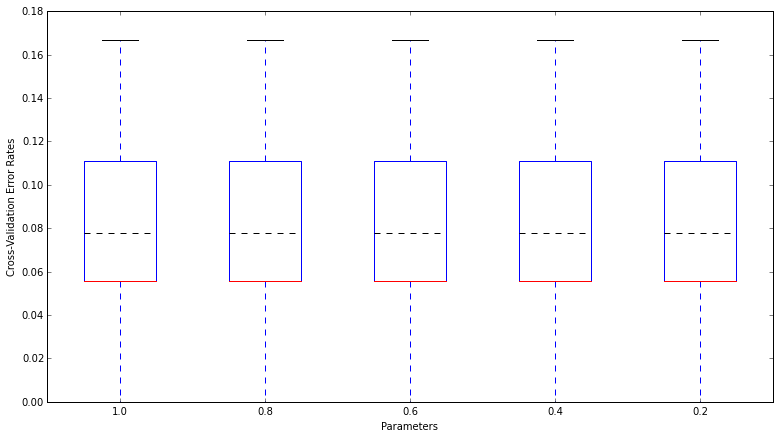

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 18
Beta: [  10.75207113   65.30966446 -327.02970071 -111.20961076  679.99557753
 -429.03327735  -58.32605897]
###########################################################


###########################################################
Dataset: 19
Best alpha: 1.0


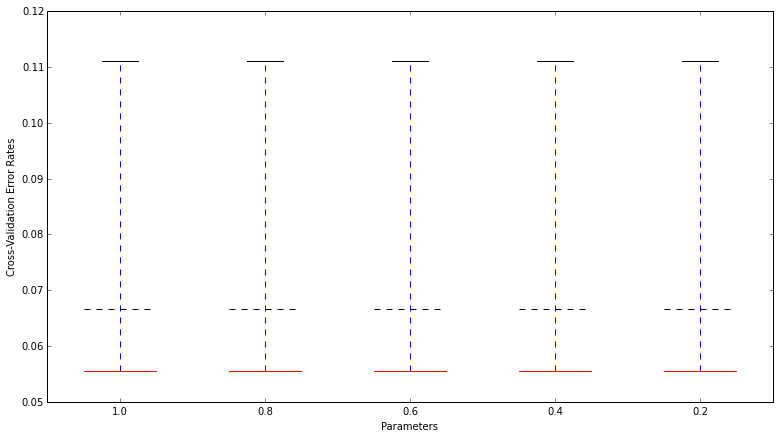

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 17
Beta: [ -39.15312964    8.74656709 -223.19073575  -78.77128686  333.10302396
 -220.69299586    6.32142907]
###########################################################




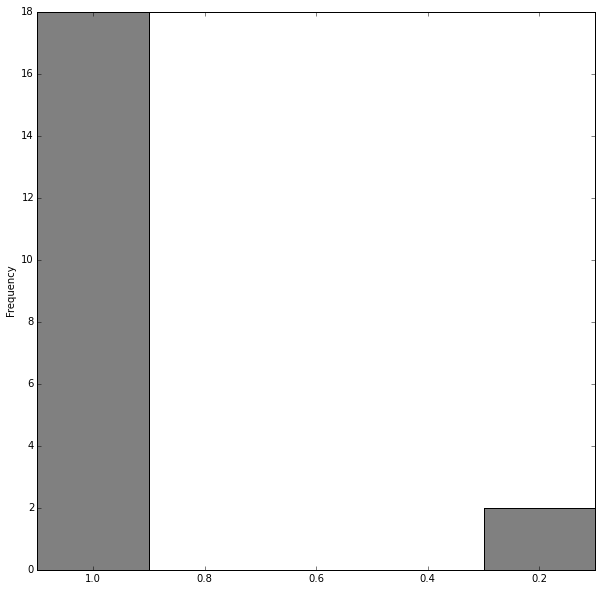

In [69]:
solve_logistic(nr_logistic, params1, normalize)

### Stochastic Gradient Ascent with raw data

###########################################################
Dataset: 0
Best alpha: 0.00775


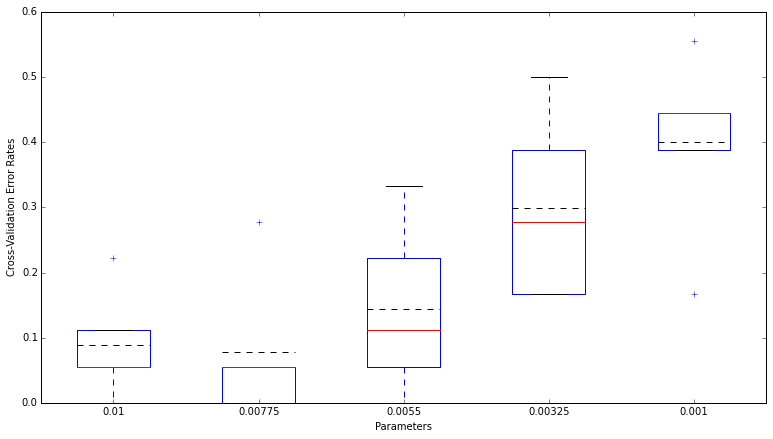

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 13625
Beta: [ -6.07258811e+00   7.03329870e+00  -8.26724873e+00  -2.25430210e-01
   1.24680827e+02  -2.80636719e+02   3.07024050e+00]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.00775


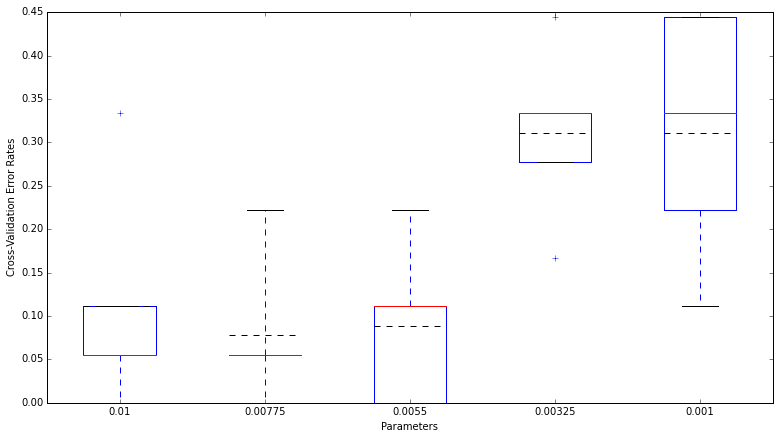

Training error rate: 0.0444444444444
Testing error rate: 0.0333333333333
N° iterations: 4532
Beta: [  1.39397700e+01   2.68882773e+00  -3.81370869e+00  -1.15026941e-01
   6.81616069e+01  -1.66599139e+02   1.03962423e+00]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


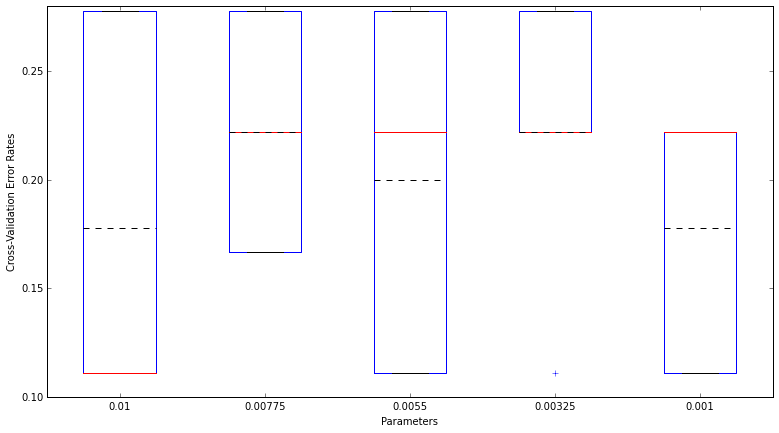

Training error rate: 0.266666666667
Testing error rate: 0.333333333333
N° iterations: 6
Beta: [ 0.00078456  0.07117325 -0.07339396 -0.17267994  0.20611476 -0.0488618
  0.07268717]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.00775


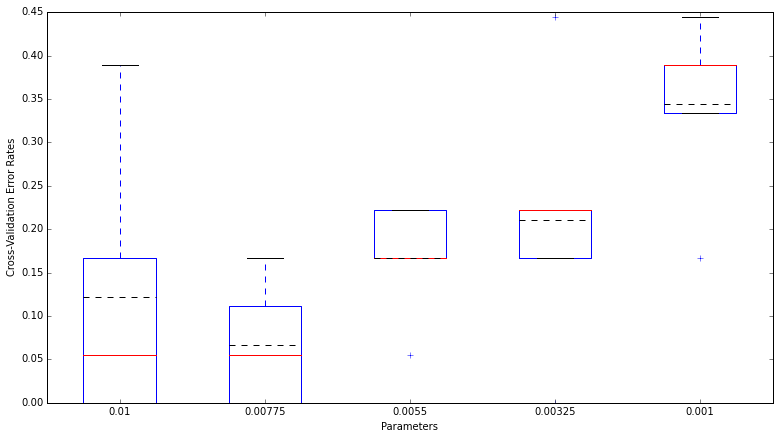

Training error rate: 0.0666666666667
Testing error rate: 0.0333333333333
N° iterations: 3996
Beta: [  8.84858725e+00   1.58467517e+00  -1.85786594e+00  -9.73318397e-02
   3.94725569e+01  -1.19620686e+02  -5.06208452e-01]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.00775


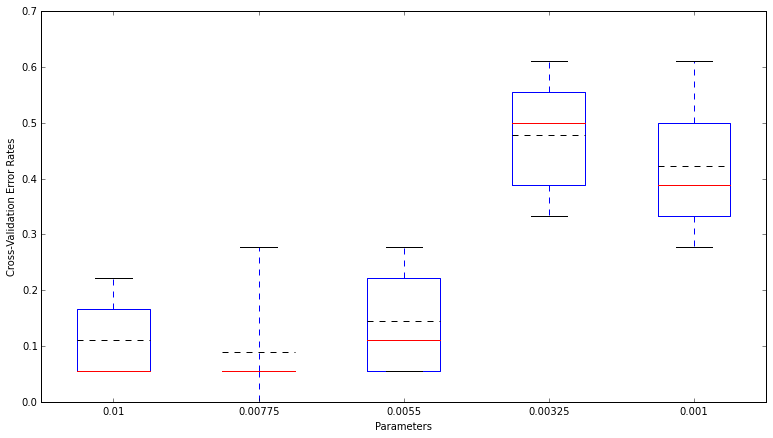

Training error rate: 0.0666666666667
Testing error rate: 0.1
N° iterations: 4301
Beta: [  12.03052244    2.15761377   -2.78153442   -0.53657607   65.79190259
 -171.05440733   -0.76790752]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0055


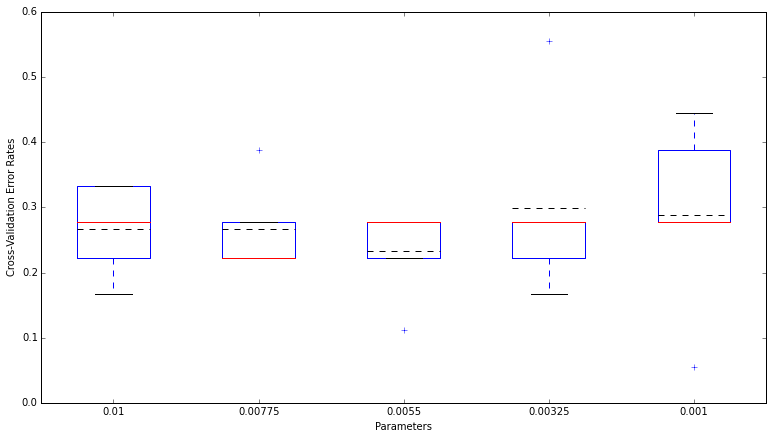

Training error rate: 0.188888888889
Testing error rate: 0.166666666667
N° iterations: 414
Beta: [  0.68995754   0.72190427  -1.81214632  -0.15788242  22.32189175
 -13.77235401   1.13083393]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.0055


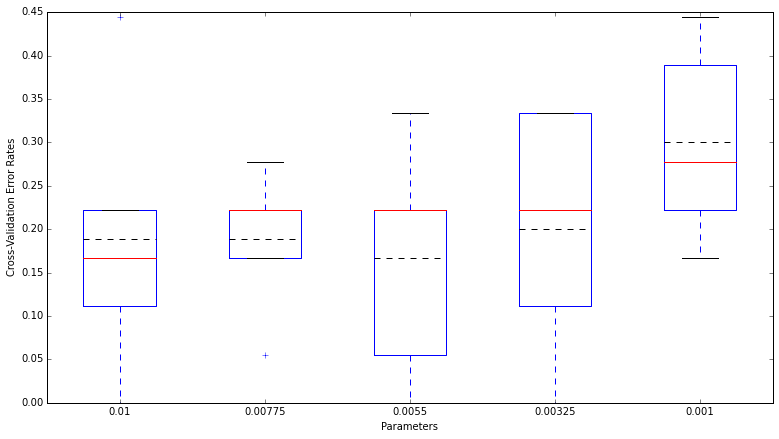

Training error rate: 0.0777777777778
Testing error rate: 0.233333333333
N° iterations: 596
Beta: [  1.48826461   0.46112061  -1.12381327  -0.09582588  19.13158315
 -25.75814648  -0.28172356]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.01


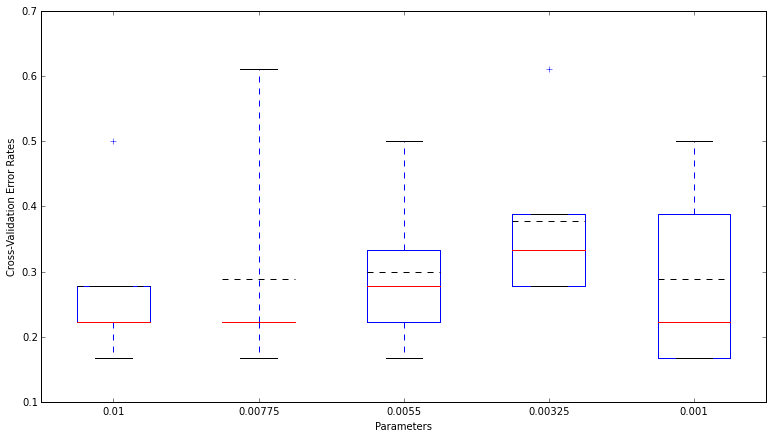

Training error rate: 0.177777777778
Testing error rate: 0.0
N° iterations: 1809
Beta: [  4.819032     1.14769472  -3.75792009  -0.47729992  52.71080298
 -99.29834878   4.36745457]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.01


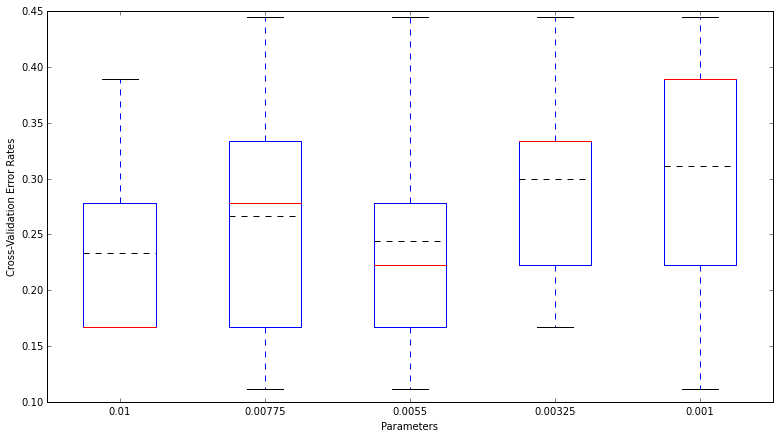

Training error rate: 0.188888888889
Testing error rate: 0.133333333333
N° iterations: 74
Beta: [  0.06266014   0.50922302  -0.72052138  -1.20956544  11.33774159
  -7.16547515   0.06123179]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.00775


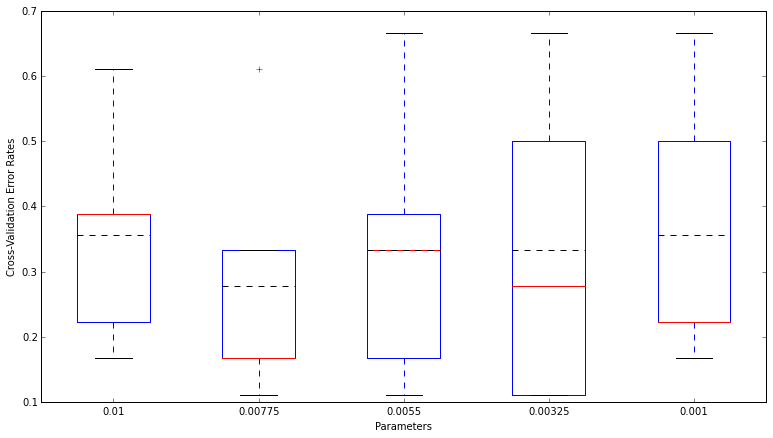

Training error rate: 0.155555555556
Testing error rate: 0.0666666666667
N° iterations: 2132
Beta: [  7.65963674   1.43622165  -2.42596716  -1.18611107  37.02808333
 -75.5053583    0.61615149]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.00775


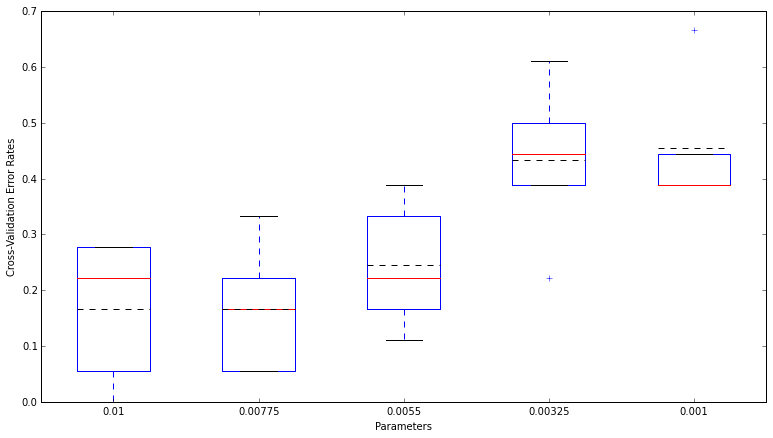

Training error rate: 0.111111111111
Testing error rate: 0.166666666667
N° iterations: 2407
Beta: [  7.33920972   1.92131447  -5.49947068  -0.79695068  58.54390171
 -77.54840753   3.96180314]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.01


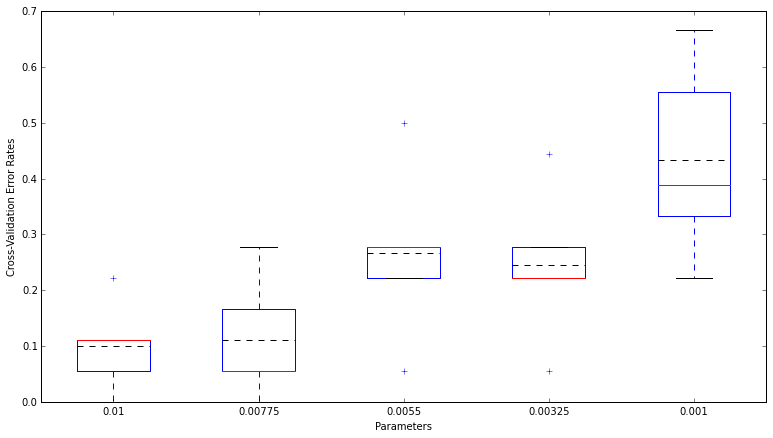

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 44740
Beta: [  36.87622116   12.75983167   -8.88761398   -0.66665368  202.53528304
 -638.19953371   -2.48814776]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.01


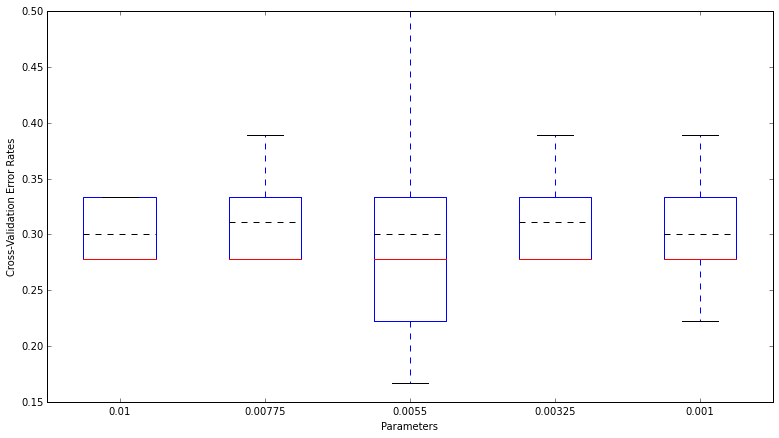

Training error rate: 0.2
Testing error rate: 0.133333333333
N° iterations: 184
Beta: [  0.79892702   1.11264225  -1.78900717  -1.5772789   23.24244469
 -13.79951207  -0.06652133]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.01


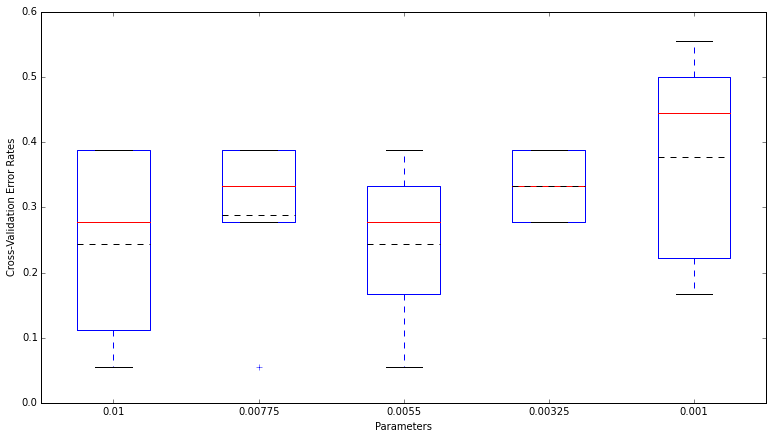

Training error rate: 0.277777777778
Testing error rate: 0.366666666667
N° iterations: 57
Beta: [ 0.15367531  0.05061414 -1.0258706  -0.74262226  8.70880191 -5.0576571
  0.33988046]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0055


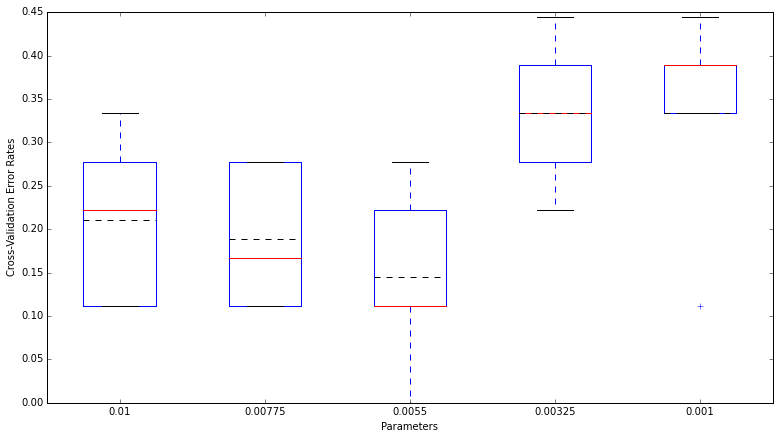

Training error rate: 0.155555555556
Testing error rate: 0.166666666667
N° iterations: 100000
Beta: [  85.582449      5.51768624   -6.92887744    0.90383805  137.34901635
 -394.48396529    0.9807746 ]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.01


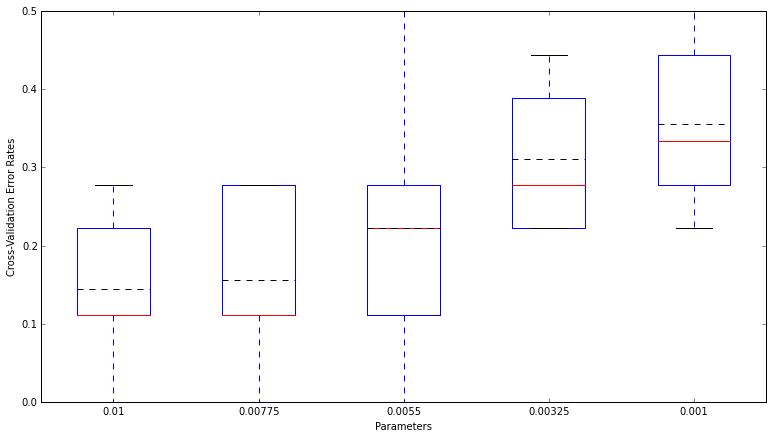

Training error rate: 0.144444444444
Testing error rate: 0.0666666666667
N° iterations: 3094
Beta: [  20.19591794    2.21040014   -6.79899146   -0.28270267   75.32196545
 -172.05951715    4.79596258]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.01


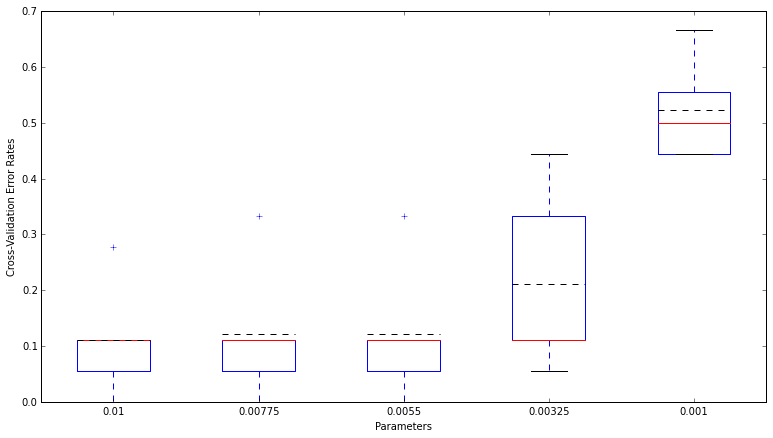

Training error rate: 0.0444444444444
Testing error rate: 0.133333333333
N° iterations: 49260
Beta: [  6.20307135e+01   1.38185722e+01  -1.61679258e+01  -8.95780308e-01
   2.41061249e+02  -5.11305917e+02   3.14220042e-01]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.01


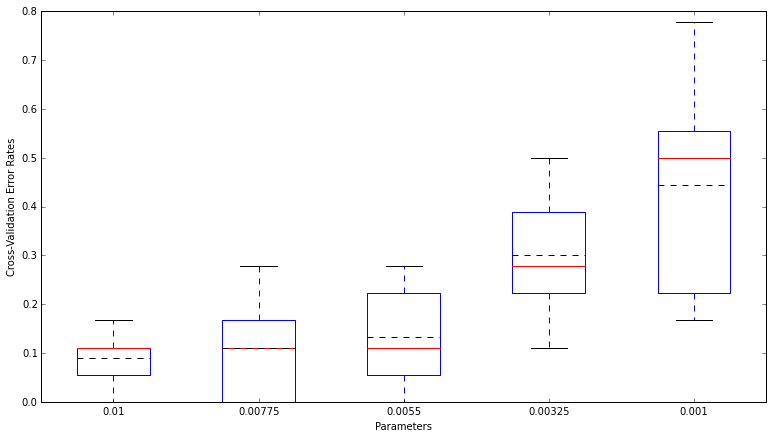

Training error rate: 0.0555555555556
Testing error rate: 0.0666666666667
N° iterations: 5326
Beta: [  2.46317890e+00   1.58788503e+00  -6.89622813e+00  -1.48272351e-01
   9.69028681e+01  -2.16158224e+02   7.25580149e+00]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.01


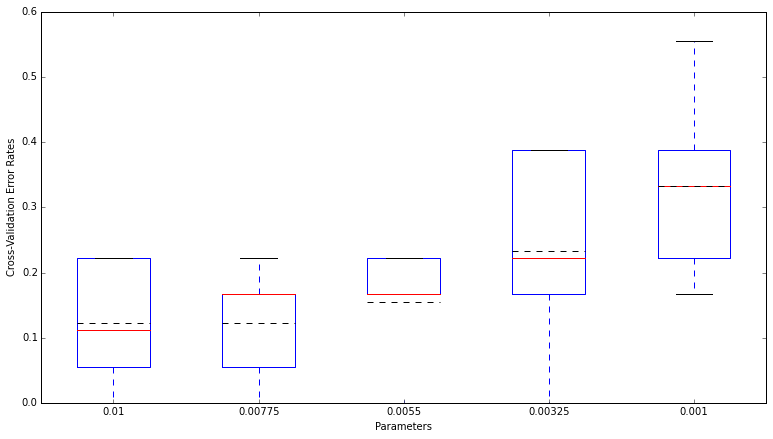

Training error rate: 0.0222222222222
Testing error rate: 0.1
N° iterations: 100000
Beta: [  1.15200772e+02   1.32387394e+01  -6.94189213e+00  -1.08565965e-01
   2.57218860e+02  -7.02141415e+02  -2.14376597e+01]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.00775


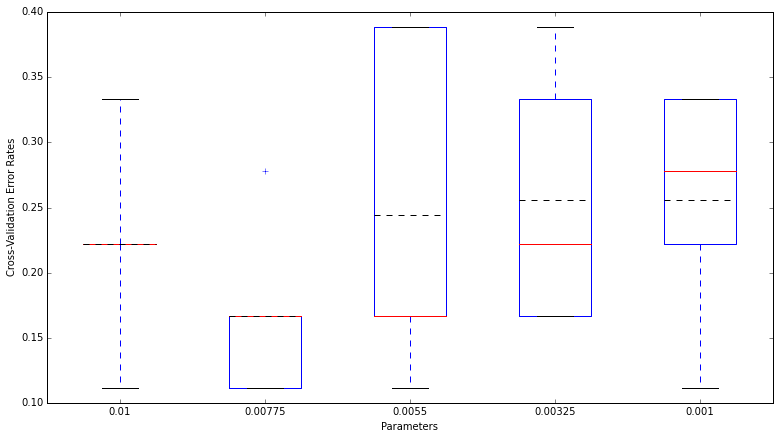

Training error rate: 0.188888888889
Testing error rate: 0.266666666667
N° iterations: 411
Beta: [  1.32093098   0.33204626  -0.90607565  -1.334604    17.75227861
 -27.50432835  -0.49635012]
###########################################################




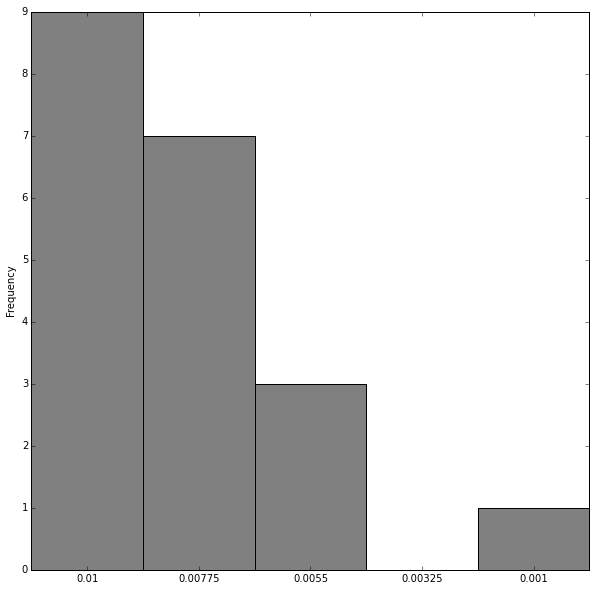

In [72]:
solve_logistic(gd_stochastic, params2)

### Stochastic Gradient Ascent with rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.01


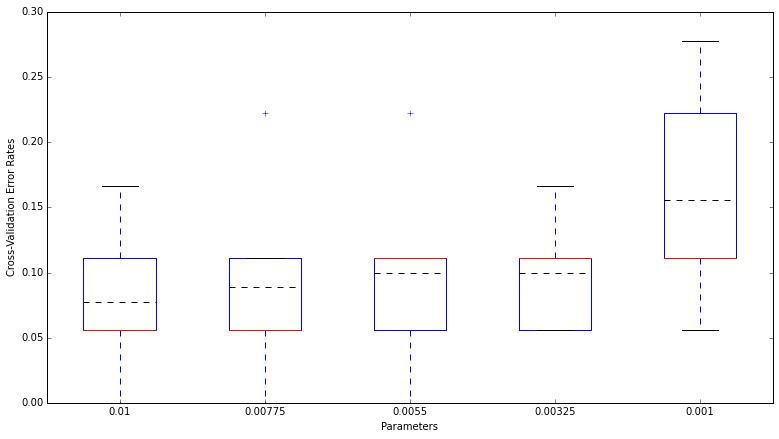

Training error rate: 0.0666666666667
Testing error rate: 0.1
N° iterations: 364
Beta: [-0.89067992  1.89240682 -3.06533656 -0.49413702  8.38805164 -3.67234941
  1.39561496]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.01


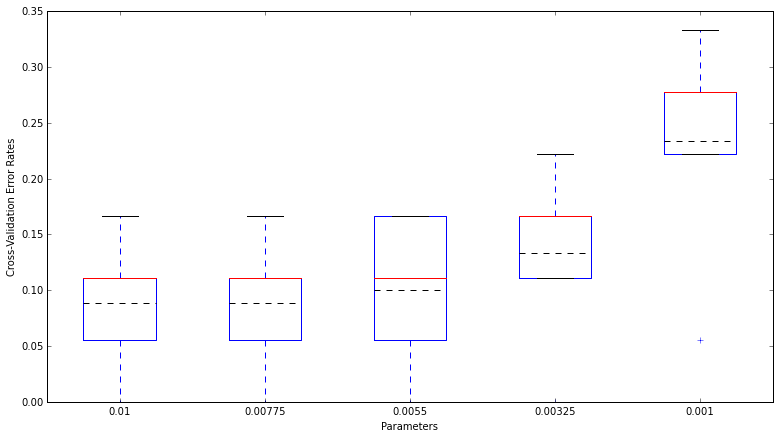

Training error rate: 0.0555555555556
Testing error rate: 0.0
N° iterations: 379
Beta: [-0.7977968   1.54445852 -2.97341225 -0.36210483  9.01557997 -3.62947593
  0.64499892]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.01


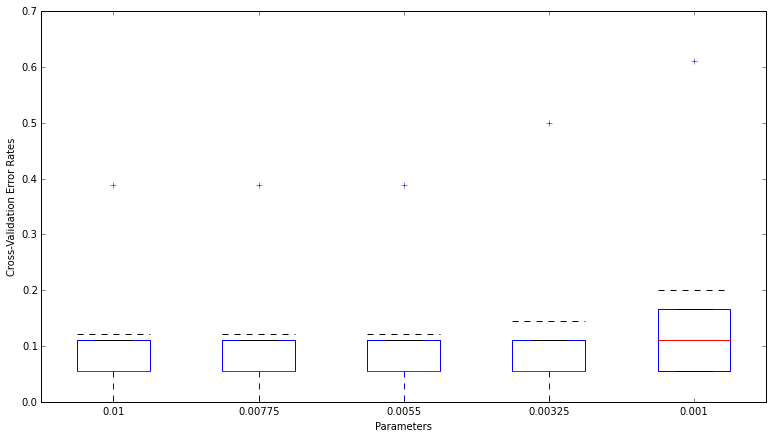

Training error rate: 0.0444444444444
Testing error rate: 0.3
N° iterations: 402
Beta: [-0.82197098  1.86769441 -2.47377512 -1.24139366  8.63545372 -4.64343087
  0.46661589]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.01


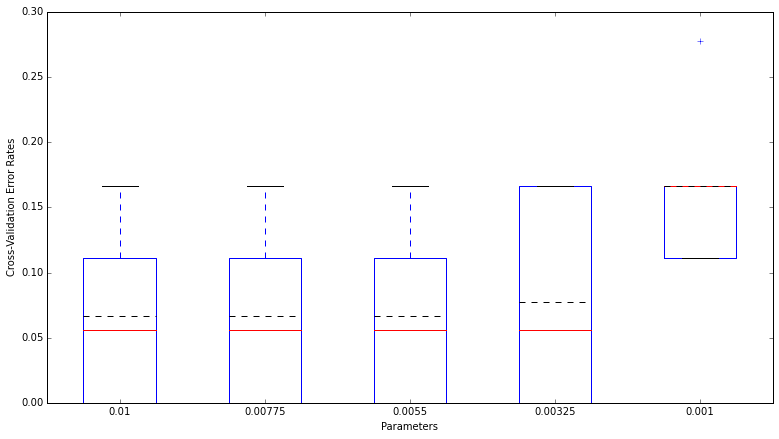

Training error rate: 0.0555555555556
Testing error rate: 0.166666666667
N° iterations: 396
Beta: [-0.72765882  1.55981017 -3.1747395   0.27168408  9.03170782 -4.02811771
  1.29282542]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.01


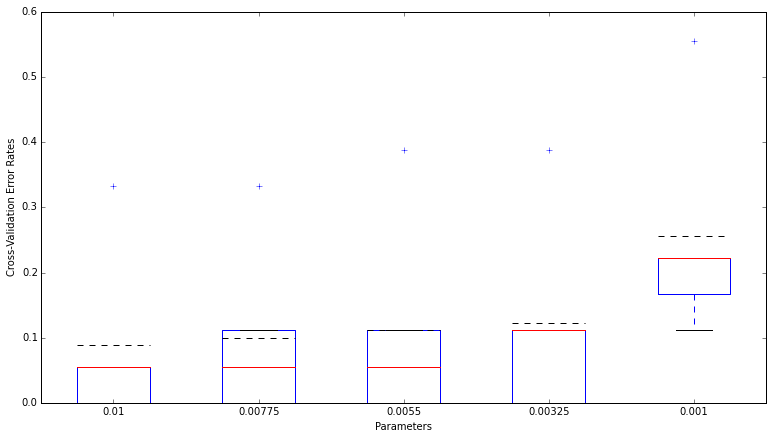

Training error rate: 0.0777777777778
Testing error rate: 0.0333333333333
N° iterations: 364
Beta: [-0.94453222  1.31056943 -2.72677803 -0.1923974   8.85996276 -3.56808918
  1.12277214]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.01


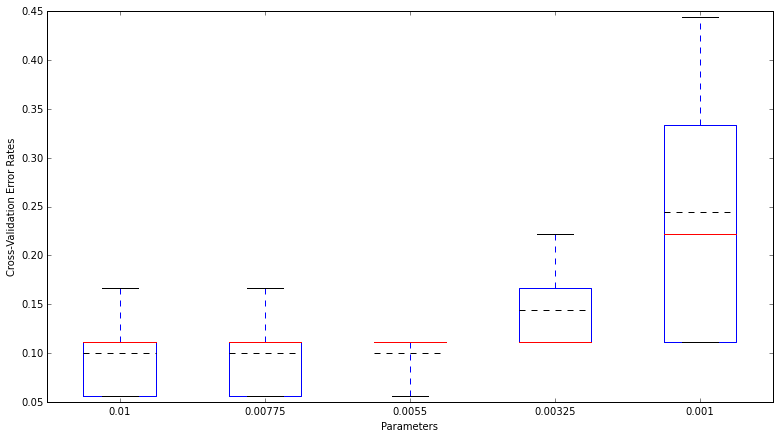

Training error rate: 0.0777777777778
Testing error rate: 0.0333333333333
N° iterations: 345
Beta: [-0.74162556  1.4898758  -2.60540736 -0.28340711  8.41126978 -3.67581811
  1.0686598 ]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.01


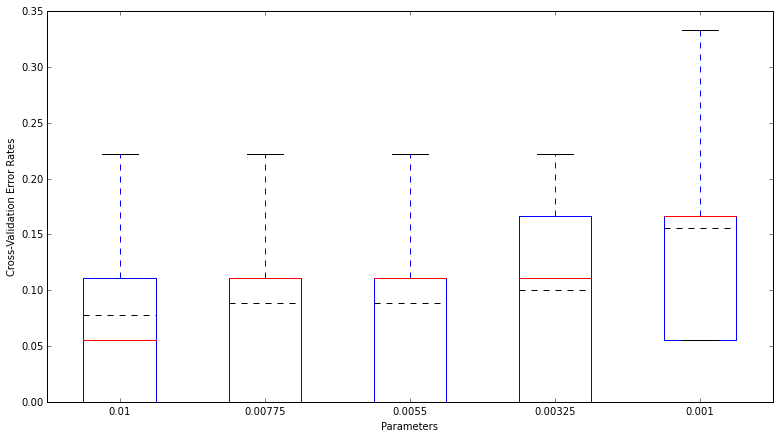

Training error rate: 0.0555555555556
Testing error rate: 0.1
N° iterations: 364
Beta: [-0.59329362  1.53771939 -3.12881946 -0.80952021  8.371041   -3.9875623
  0.83697402]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.00775


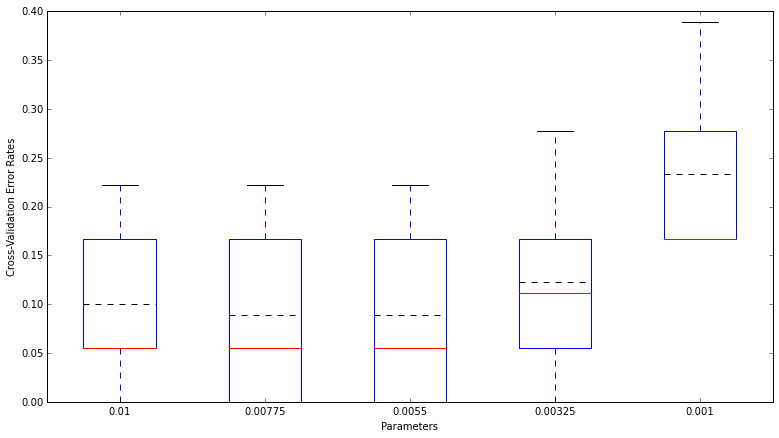

Training error rate: 0.0888888888889
Testing error rate: 0.0666666666667
N° iterations: 342
Beta: [-0.83976387  1.25307919 -2.67549851  0.1787433   7.07378961 -3.29163361
  1.55058355]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.01


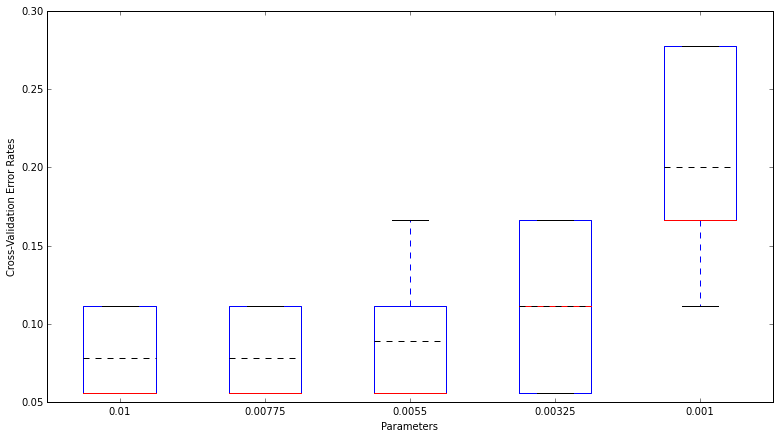

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 380
Beta: [-0.57858184  1.58903236 -2.93396792 -0.83510132  8.57879803 -4.29191283
  1.07620324]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.01


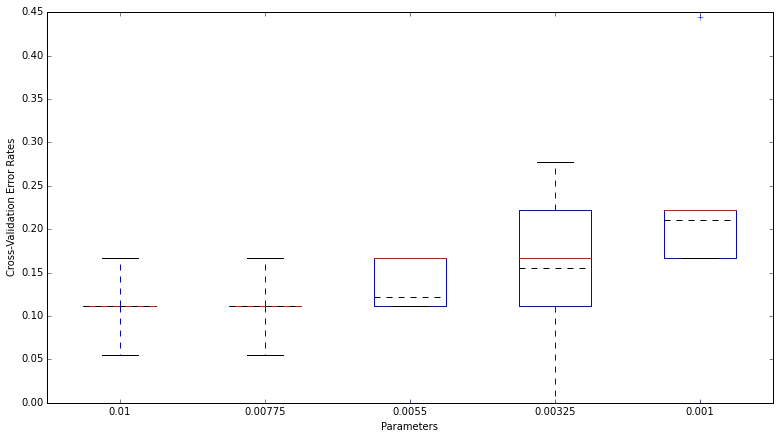

Training error rate: 0.0777777777778
Testing error rate: 0.1
N° iterations: 336
Beta: [-0.85839435  1.78888827 -3.17413174 -0.4561903   8.26186295 -3.35887411
  1.17395055]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.01


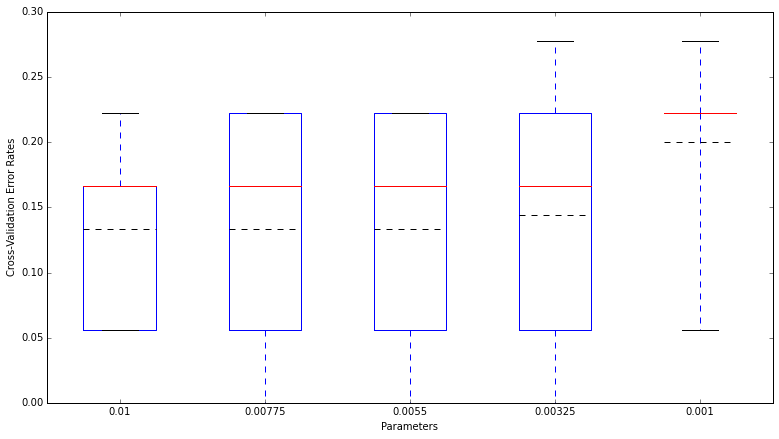

Training error rate: 0.0666666666667
Testing error rate: 0.1
N° iterations: 361
Beta: [-0.84578381  1.7966018  -3.4608966  -0.58541564  8.51634031 -3.83388417
  0.90410151]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.01


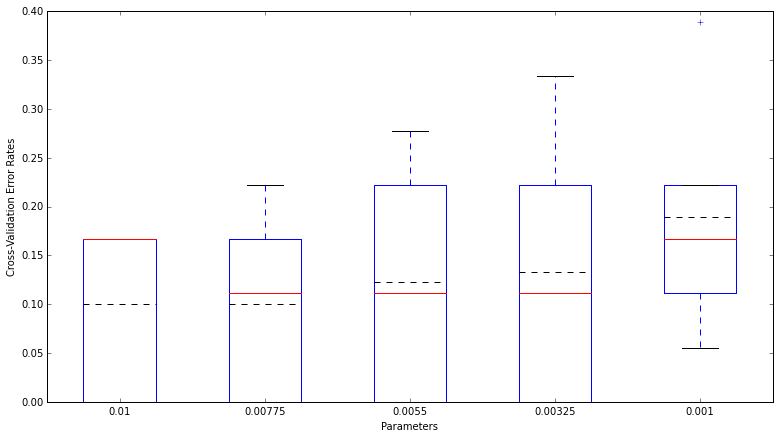

Training error rate: 0.0666666666667
Testing error rate: 0.133333333333
N° iterations: 389
Beta: [-0.75673003  1.62722846 -2.39269898 -0.06539668  8.72669882 -3.97114571
  1.15819496]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.01


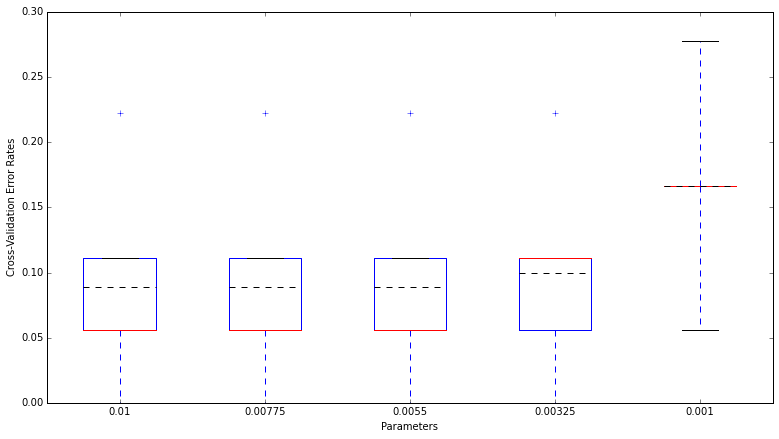

Training error rate: 0.0777777777778
Testing error rate: 0.133333333333
N° iterations: 345
Beta: [-0.36155229  1.41984797 -3.08758012 -0.179257    8.13502464 -3.77186421
  1.5576084 ]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.01


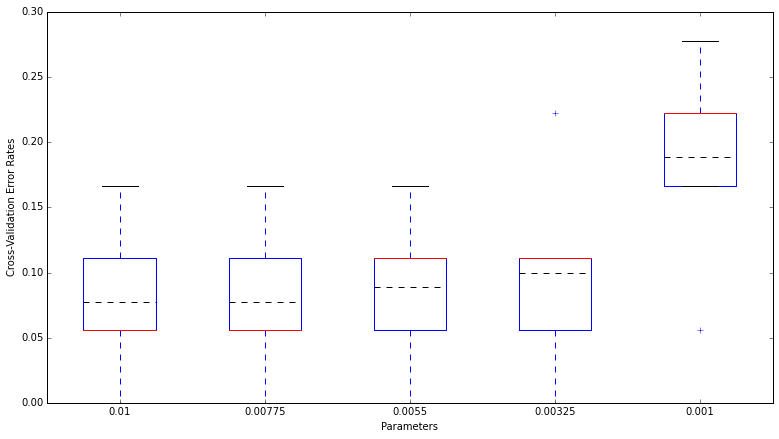

Training error rate: 0.0555555555556
Testing error rate: 0.1
N° iterations: 347
Beta: [-0.50483633  1.79526833 -3.45548537 -0.93222111  7.83627124 -3.68111582
  1.12074998]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.01


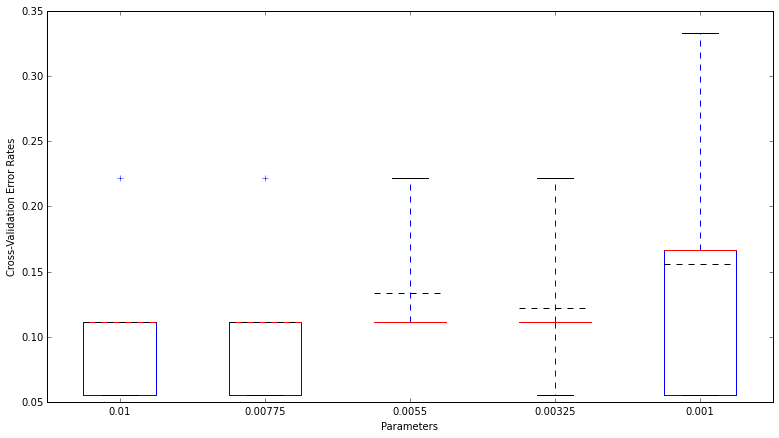

Training error rate: 0.0888888888889
Testing error rate: 0.1
N° iterations: 341
Beta: [-0.86739457  2.20861945 -2.52849556 -0.58885793  8.37423558 -3.46780645
  0.54455779]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.00775


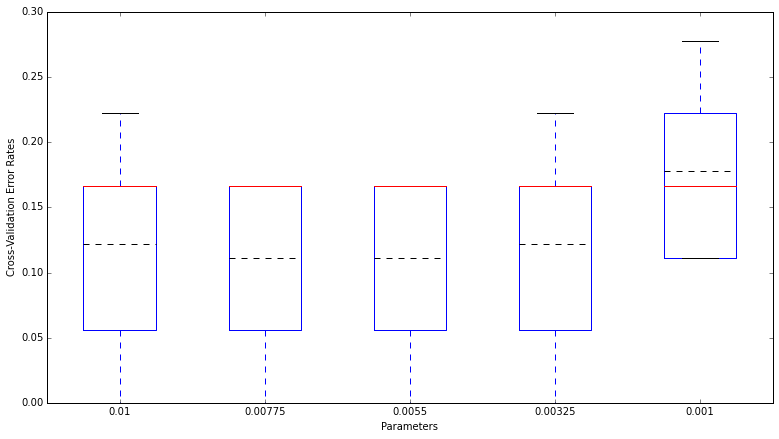

Training error rate: 0.0777777777778
Testing error rate: 0.0666666666667
N° iterations: 372
Beta: [-0.29159903  1.55713932 -2.92791868 -0.41951795  7.48917894 -3.64664765
  1.34381963]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.01


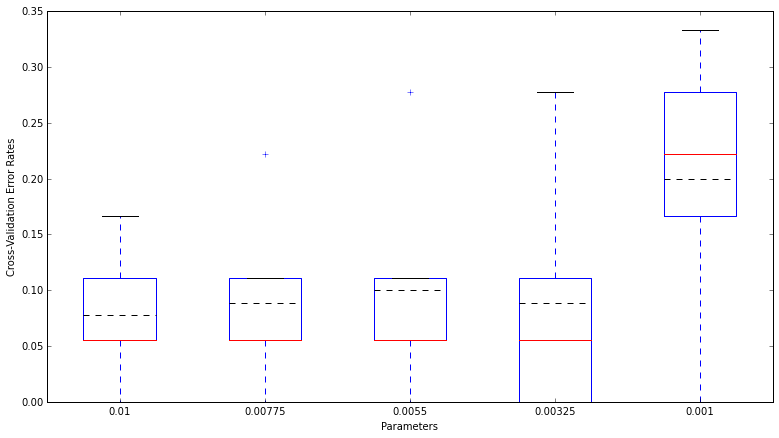

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 424
Beta: [-1.26486707  1.56450701 -2.5092271  -0.44068487  9.87874835 -3.70740889
  1.20088111]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.0055


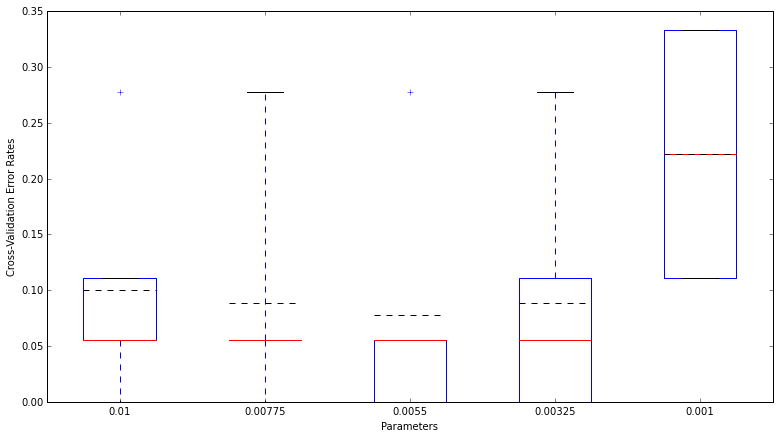

Training error rate: 0.0666666666667
Testing error rate: 0.0333333333333
N° iterations: 389
Beta: [-0.38604815  0.91943436 -2.64866502 -0.14853692  6.58150261 -3.11148171
  1.30324288]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.00325


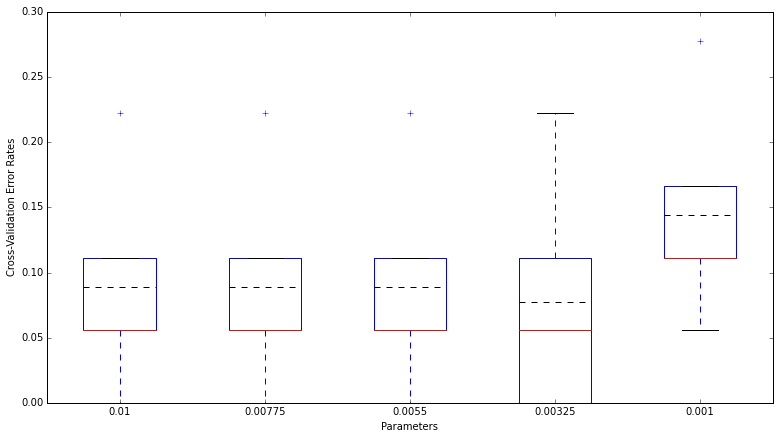

Training error rate: 0.0777777777778
Testing error rate: 0.133333333333
N° iterations: 375
Beta: [-0.42062079  1.37668645 -1.66970944 -0.31830059  4.65288428 -2.81723647
  0.81825293]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.01


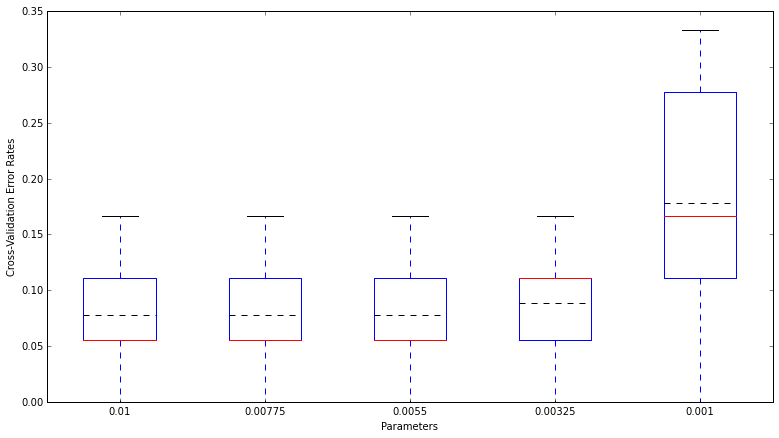

Training error rate: 0.0444444444444
Testing error rate: 0.2
N° iterations: 382
Beta: [-0.27112299  2.01578457 -3.2341504  -1.31073649  7.84996726 -4.65899607
  0.96075731]
###########################################################




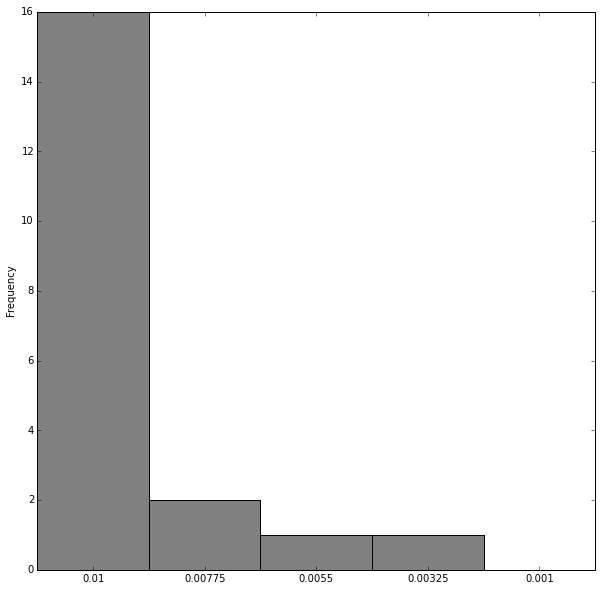

In [71]:
solve_logistic(gd_stochastic, params2, rescale)

### Stochastic Gradient Ascent with normalized data

###########################################################
Dataset: 0
Best alpha: 0.00325


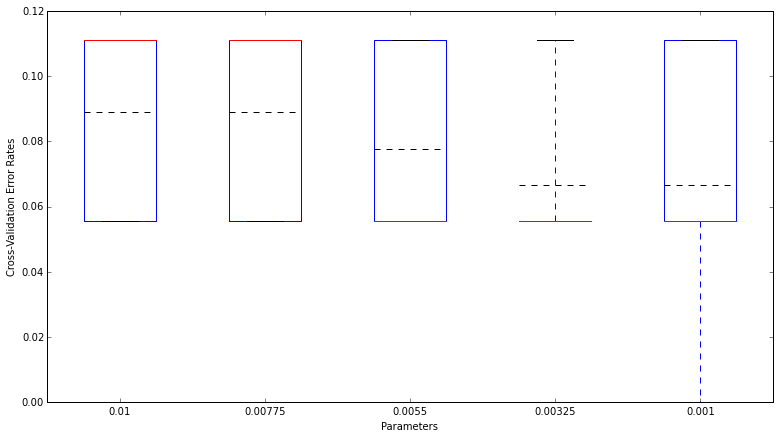

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 345
Beta: [-0.2385682   0.81850858 -1.27981156 -0.11349321  3.88872458 -2.76731914
  0.40282272]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001


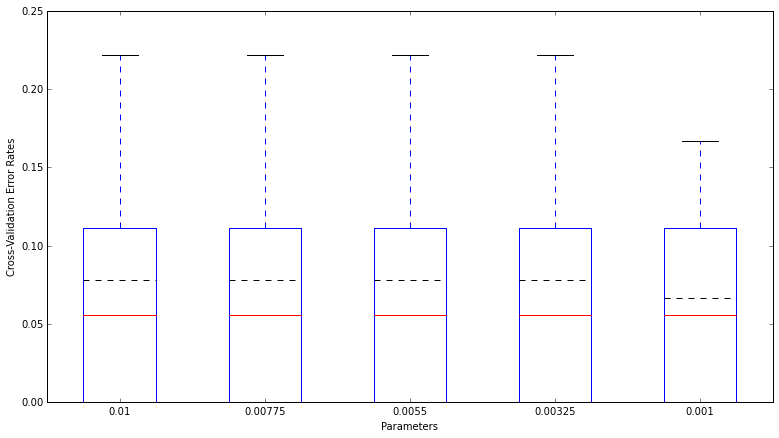

Training error rate: 0.0444444444444
Testing error rate: 0.1
N° iterations: 381
Beta: [-0.43673509  0.48949661 -0.86967501 -0.03263287  2.56603959 -1.86605867
  0.16742588]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.00325


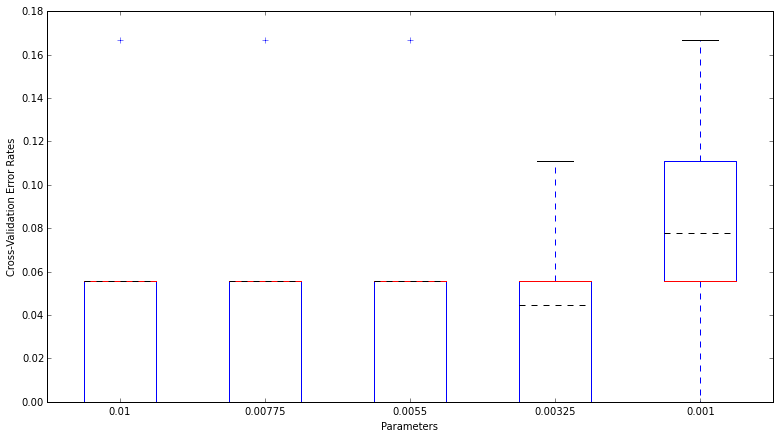

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 406
Beta: [-0.66066299  0.65012066 -1.22916272 -0.56208751  3.90360994 -3.36140734
 -0.01055831]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.01


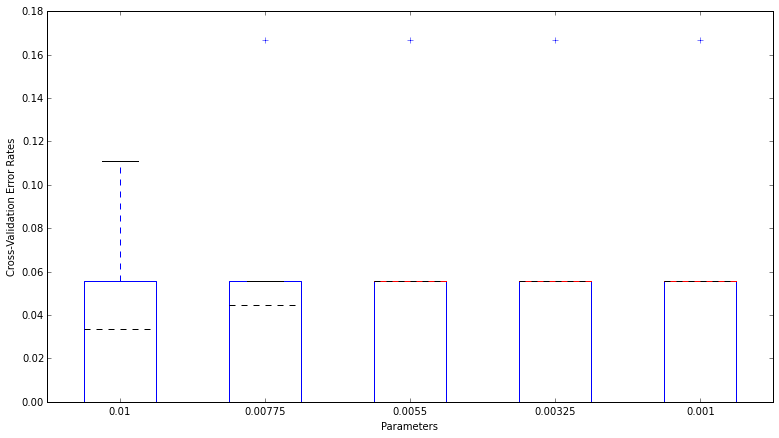

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 417
Beta: [ 0.23436873  0.90426244 -2.19674748  0.5126263   6.66795523 -4.40844942
  0.65262352]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.00325


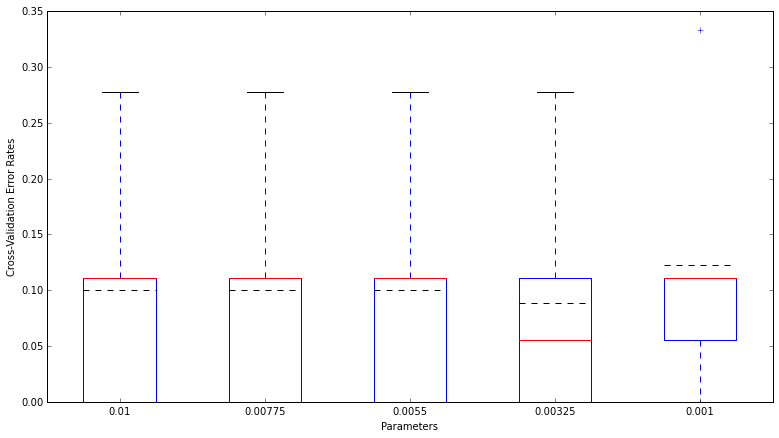

Training error rate: 0.0444444444444
Testing error rate: 0.166666666667
N° iterations: 333
Beta: [-0.8737307   0.58037268 -1.26681579 -0.03986278  4.04395146 -2.6648584
  0.25793967]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.01


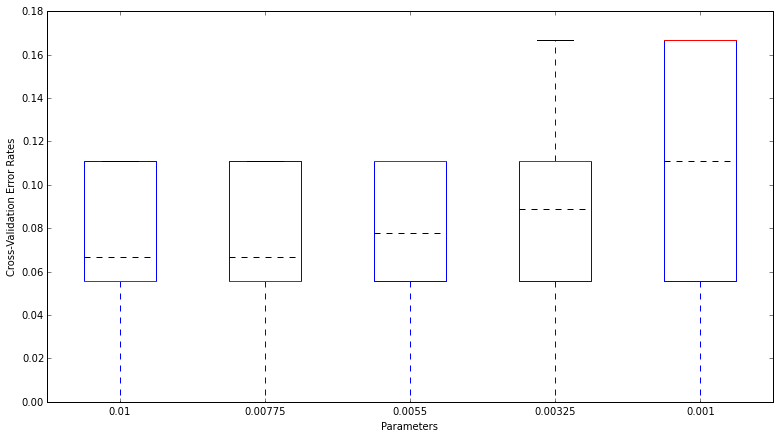

Training error rate: 0.0333333333333
Testing error rate: 0.0333333333333
N° iterations: 273
Beta: [-0.42835605  0.58105032 -2.2013754  -0.42018574  5.41651509 -3.71121414
  0.18045007]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.01


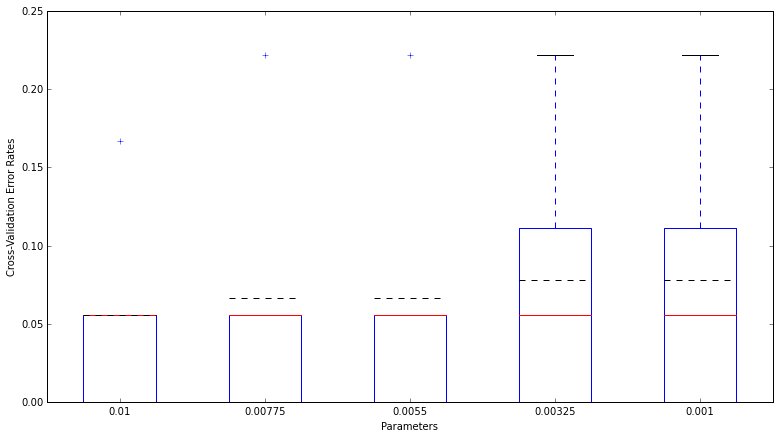

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 367
Beta: [-0.11506856  0.17614119 -2.85130922 -0.67537837  5.83775885 -4.1812877
 -0.00781559]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.001


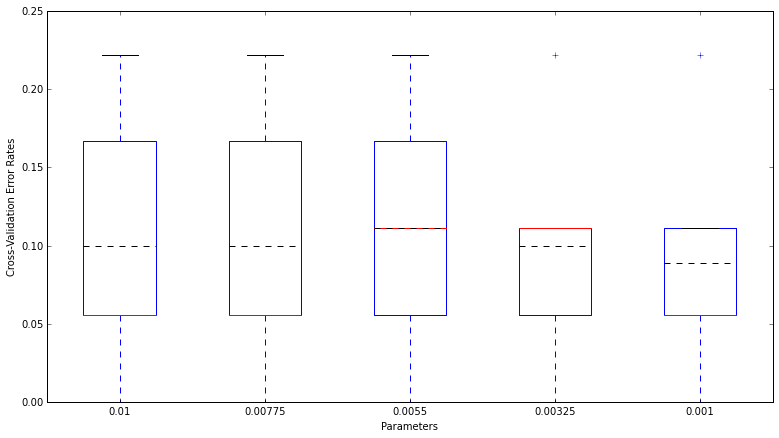

Training error rate: 0.0666666666667
Testing error rate: 0.0666666666667
N° iterations: 344
Beta: [-0.43410122  0.49620394 -0.81536076  0.22003109  2.35402154 -1.78720476
  0.46463157]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.01


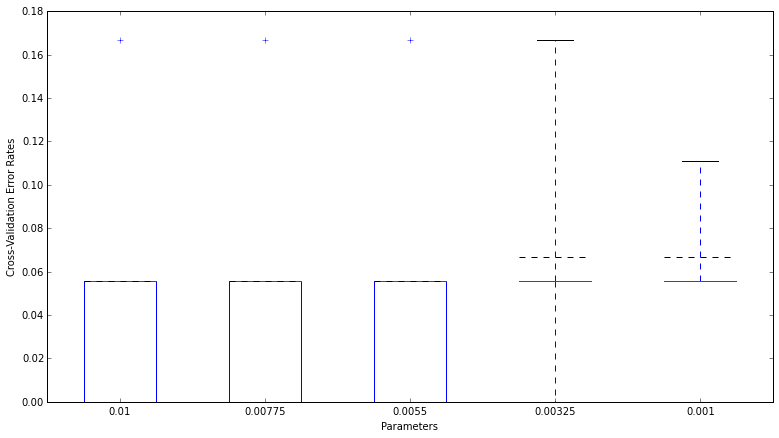

Training error rate: 0.0222222222222
Testing error rate: 0.1
N° iterations: 347
Beta: [ 0.42075672  0.44684686 -2.5142354  -0.89729122  5.7558375  -4.52637506
  0.14340264]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.01


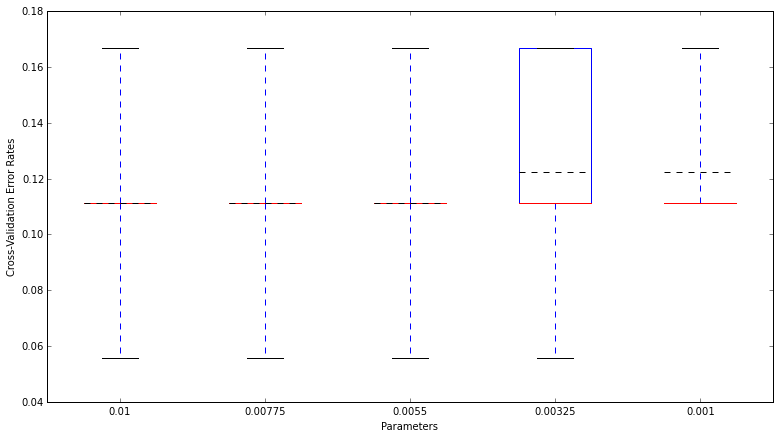

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 261
Beta: [ 0.26206927  0.91024483 -1.98647447 -0.50841409  5.52509058 -3.50126224
  0.15273246]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.01


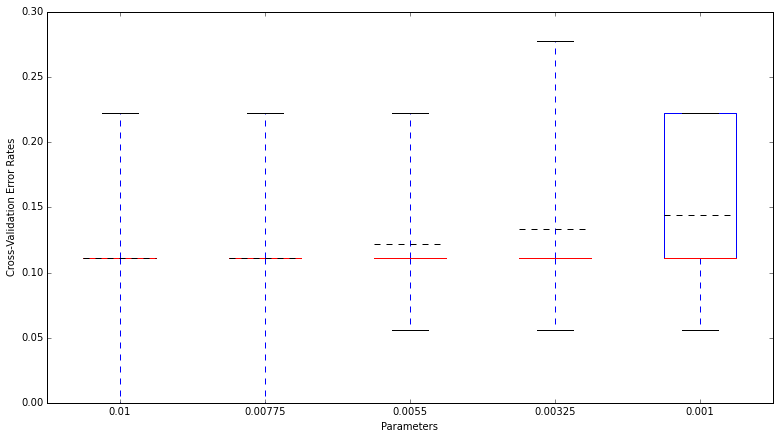

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 331
Beta: [-0.33342587  0.61540488 -2.70893915 -0.73571677  5.840551   -3.95631366
  0.13537712]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.01


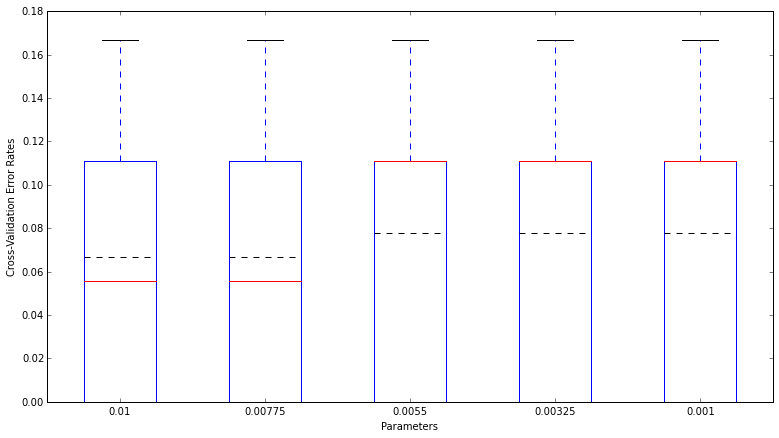

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 270
Beta: [-0.48227596  0.71199095 -1.79284653 -0.12417535  5.1279277  -4.08278391
  0.10522071]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0055


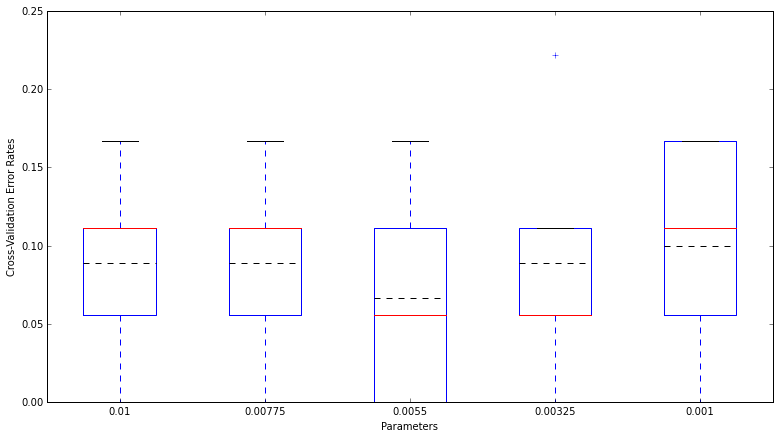

Training error rate: 0.0555555555556
Testing error rate: 0.0
N° iterations: 299
Beta: [ 0.17044196  0.45308749 -1.87037632 -0.30052514  4.42832841 -3.13506894
  0.17690918]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.001


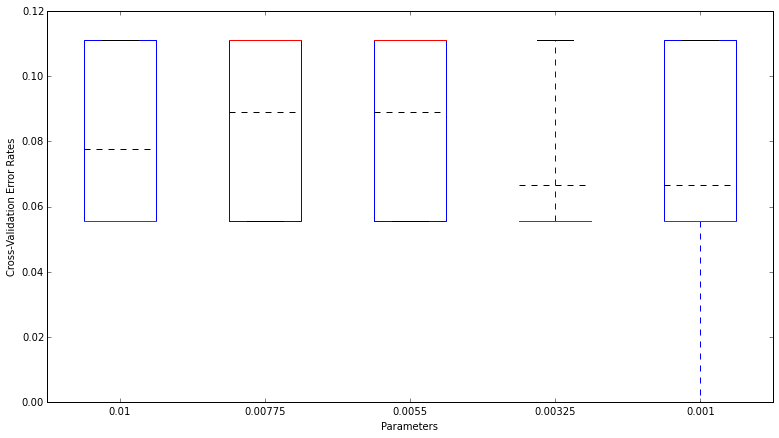

Training error rate: 0.0555555555556
Testing error rate: 0.1
N° iterations: 355
Beta: [-0.50016906  0.53004321 -0.98352171 -0.24551617  2.2574249  -1.87047563
  0.28379127]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0055


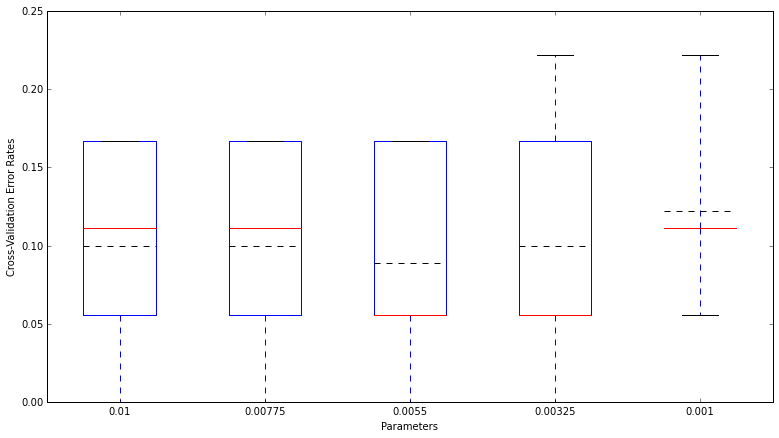

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 290
Beta: [ 0.20829953  1.02332025 -1.47941872 -0.31923802  4.65487619 -3.11664099
  0.09574176]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.0055


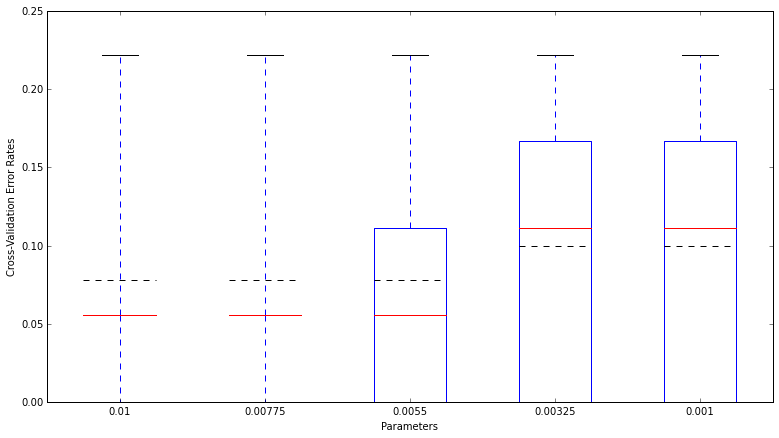

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 314
Beta: [ 0.16657053  0.40379711 -1.97127706 -0.4244026   4.42795913 -3.45297835
  0.2969193 ]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.01


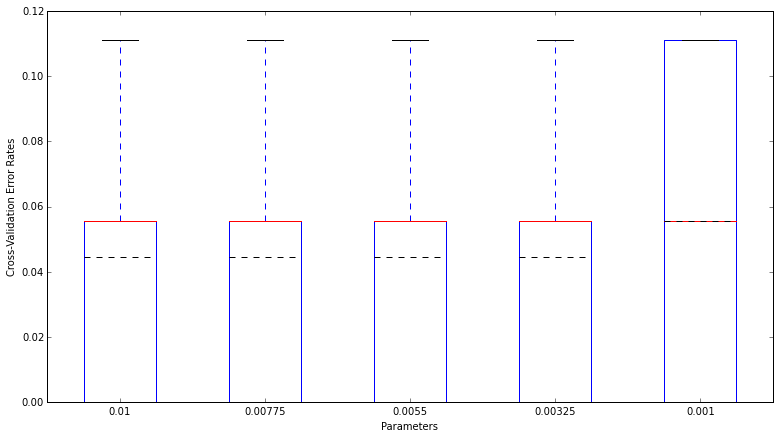

Training error rate: 0.0333333333333
Testing error rate: 0.133333333333
N° iterations: 373
Beta: [ -3.84568464e-03   1.24067578e+00  -1.70249891e+00  -3.85842333e-01
   6.49482736e+00  -3.87871177e+00   2.58547441e-01]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.01


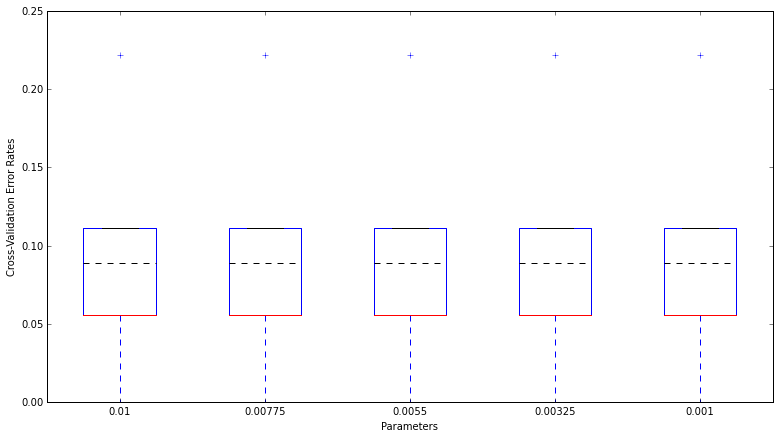

Training error rate: 0.0333333333333
Testing error rate: 0.133333333333
N° iterations: 346
Beta: [ 0.04915599  0.6153901  -2.37532124 -0.55551818  6.11393304 -3.85604403
 -0.13667383]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.01


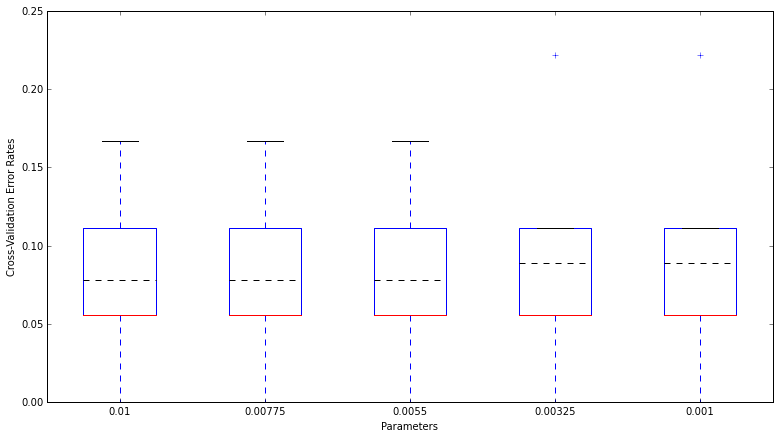

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 309
Beta: [-0.17553501  0.74503715 -1.62688543  0.08890839  5.66141142 -3.95215386
 -0.08901403]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.01


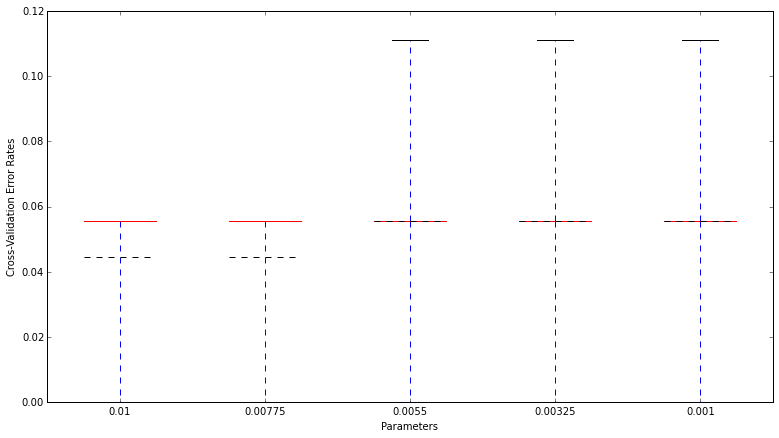

Training error rate: 0.0111111111111
Testing error rate: 0.133333333333
N° iterations: 372
Beta: [-0.85310356  0.3924399  -2.64878155 -1.20552204  5.30012333 -4.38689523
 -0.30190939]
###########################################################




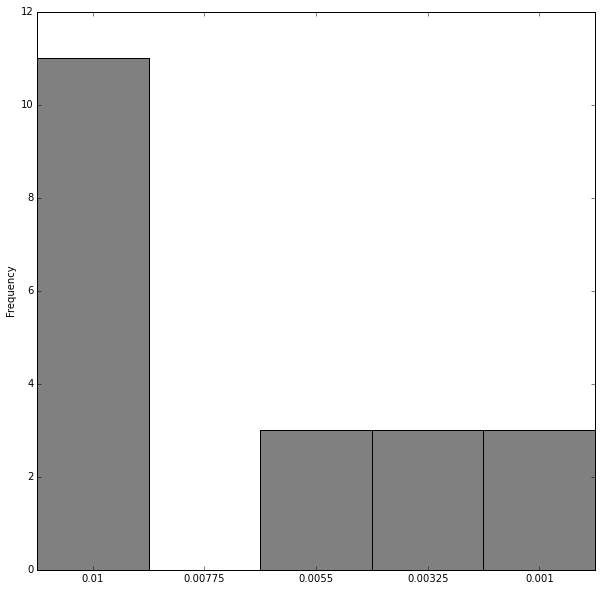

In [70]:
solve_logistic(gd_stochastic, params2, normalize)